# Прогноз оттока клиентов

## Цель и этапы исследования

В данном проекте мы проанализируем данные о клиентах оператора связи: информацию об их тарифах и договорах, персональные данные.

Оператор предоставляет два основных типа услуг: стационарную телефонную связь и интернет. И дополнительные услуги: возможность подключения телефонного аппарата к нескольким линиям одновременно, антивирус, блокировку небезопасных сайтов, выделенную линию технической поддержки, облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов.

**Цель проекта:**

Создать прототип модели машинного обучения, прогнозирующей отток клиентов. 

**Метрики качества**

В качестве метрики качества модели используем `ROC-AUC`, дополнительно будем измерять `Accuracy`


**Ход исследования**

Исследование пройдёт в четыре этапа:

- Подготовка данных
- Анализ данных
- Построение модели
- Отчет

## Вопросы заказчику:
1. В каких единицах выражены ежемесячые и общие траты?

In [1]:
# Импортиуем библиотеки
import pandas as pd

import numpy as np
from numpy import argmax

import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import re

!pip install phik -q
import phik

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

!pip install optuna -q
import optuna
from optuna.integration import OptunaSearchCV

import lightgbm as lgb

from catboost import CatBoostClassifier, Pool, cv

import warnings; warnings.filterwarnings('ignore')

## Открытие файлов и изучение общей информации

In [2]:
# Открываем файлы

names = ['contract', 'personal', 'internet', 'phone']

for n in names:
    try:
        globals()[n] = pd.read_csv(f'/datasets/{n}_new.csv')
    except:
        globals()[n] = pd.read_csv(f'https://code.s3.yandex.net/datasets/{n}_new.csv')

In [3]:
# Изучаем информацию
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract.head(10)

customerID   BeginDate     EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01          No        One year               No   
2  3668-QPYBK  2019-10-01          No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01          No        One year               No   
4  9237-HQITU  2019-09-01          No  Month-to-month              Yes   
5  9305-CDSKC  2019-03-01          No  Month-to-month              Yes   
6  1452-KIOVK  2018-04-01          No  Month-to-month              Yes   
7  6713-OKOMC  2019-04-01          No  Month-to-month               No   
8  7892-POOKP  2017-07-01          No  Month-to-month              Yes   
9  6388-TABGU  2014-12-01  2017-05-01        One year               No   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  
5           Electronic check           99.65      1150.96  
6    Credit card (automatic)           89.10      2058.21  
7               Mailed check           29.75       300.48  
8           Electronic check          104.80      3573.68  
9  Bank transfer (automatic)           56.15      1628.35

In [5]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [6]:
personal.head(10)

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
5  9305-CDSKC  Female              0      No         No
6  1452-KIOVK    Male              0      No        Yes
7  6713-OKOMC  Female              0      No         No
8  7892-POOKP  Female              0     Yes         No
9  6388-TABGU    Male              0      No        Yes

In [7]:
internet .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [8]:
internet.head(10)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   
5  9305-CDSKC     Fiber optic             No           No              Yes   
6  1452-KIOVK     Fiber optic             No          Yes               No   
7  6713-OKOMC             DSL            Yes           No               No   
8  7892-POOKP     Fiber optic             No           No              Yes   
9  6388-TABGU             DSL            Yes          Yes               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
5          No         Yes             Yes  
6          No         Yes              No  
7          No          No              No  
8         Yes         Yes             Yes  
9          No          No              No

In [9]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [10]:
phone.head(10)

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
5  7892-POOKP           Yes
6  6388-TABGU            No
7  9763-GRSKD            No
8  7469-LKBCI            No
9  8091-TTVAX           Yes

В датасете `contract`и `personal` по **7043** строк и **8** и **5** столбцов соответственно. В датасете `internet` **5517** строк и **8** столбцов. В датасете `phone` **6361** и **2** столбца.

Все признаки, кроме двух, имеют тип данных *object*. Столбец `MonthlyCharges` имеет тип *float64*, столбец `SeniorCitizen` - *int64*

Целевой признак отсутствует.

## План работы

1. Предобработка данных
 
 1) Открытие файлов и изучение общей информации
 
 2) Проверка наличия дубликатов
 
 2) Объединение данных
 
 3) Создание целевого признака
 
 4) Изменение типов данных
 
 5) Обработка пропусков 
 
 
2. Исследовательский анализ и создание новых признаков
 
 1) Анализ дат начала и окончания и динамики заключения договоров
 
 2) Создание и анализ нового признака - длительность договора
 
 3) Сравнительный анализ признаков для каждого класса - портрет клиента
   - Анализ ежемесячных и общих трат
   - Анализ параметрв договора
   - Анализ персональных данных
   - Анализ основых услуг
   - Анализ дополнительных услуг
   
   4) Проверка мультиколлинеарности и корреляции признаков между собой и с целевым признаком с помощью `phik` 
   

3. Выбор признаков для обучения модели


4. Деление данных на выборки


5. Кодирование категориальных и масштабирование числовых признаков, создание пайплайнов


6. Подбор гиперпараметров с помощью GridSearchCV, RandomizedSearchCV и Optuna 


7. Обучение моделей RandomForestClassifier, LogisticRegression,  LGBMClassifier, CatBoostClassifier


8. Исследование важности признаков, отбор признаков


9. Повторное обучение моделей


10. Анализ обучения моделей, сравнение метрик


11. Выбор лучшей модели 


12. Тестирование 


13. Оценка 


14. Подготовка отчета

## Подготовка данных

### Дубликаты

In [11]:
# Проверим данные на полные дубликаты
for n in names:
    print(globals()[n].duplicated().sum())

0
0
0
0


In [12]:
# Проверим не дублируются ли идентификаторы клиентов
for n in names:
    print(globals()[n]['customerID'].duplicated().sum())

0
0
0
0


### Объединение данных

In [13]:
for n in names:
    globals()[n].set_index('customerID', inplace=True)

In [14]:
df = contract.join([personal, internet, phone,])

In [15]:
df.head(10)

BeginDate     EndDate            Type PaperlessBilling  \
customerID                                                            
7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
5575-GNVDE  2017-04-01          No        One year               No   
3668-QPYBK  2019-10-01          No  Month-to-month              Yes   
7795-CFOCW  2016-05-01          No        One year               No   
9237-HQITU  2019-09-01          No  Month-to-month              Yes   
9305-CDSKC  2019-03-01          No  Month-to-month              Yes   
1452-KIOVK  2018-04-01          No  Month-to-month              Yes   
6713-OKOMC  2019-04-01          No  Month-to-month               No   
7892-POOKP  2017-07-01          No  Month-to-month              Yes   
6388-TABGU  2014-12-01  2017-05-01        One year               No   

                        PaymentMethod  MonthlyCharges TotalCharges  gender  \
customerID                                                                   
7590-VHVEG           Electronic check           29.85        31.04  Female   
5575-GNVDE               Mailed check           56.95      2071.84    Male   
3668-QPYBK               Mailed check           53.85       226.17    Male   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.6    Male   
9237-HQITU           Electronic check           70.70        353.5  Female   
9305-CDSKC           Electronic check           99.65      1150.96  Female   
1452-KIOVK    Credit card (automatic)           89.10      2058.21    Male   
6713-OKOMC               Mailed check           29.75       300.48  Female   
7892-POOKP           Electronic check          104.80      3573.68  Female   
6388-TABGU  Bank transfer (automatic)           56.15      1628.35    Male   

            SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
customerID                                                                    
7590-VHVEG              0     Yes         No             DSL             No   
5575-GNVDE              0      No         No             DSL            Yes   
3668-QPYBK              0      No         No             DSL            Yes   
7795-CFOCW              0      No         No             DSL            Yes   
9237-HQITU              0      No         No     Fiber optic             No   
9305-CDSKC              0      No         No     Fiber optic             No   
1452-KIOVK              0      No        Yes     Fiber optic             No   
6713-OKOMC              0      No         No             DSL            Yes   
7892-POOKP              0     Yes         No     Fiber optic             No   
6388-TABGU              0      No        Yes             DSL            Yes   

           OnlineBackup DeviceProtection TechSupport StreamingTV  \
customerID                                                         
7590-VHVEG          Yes               No          No          No   
5575-GNVDE           No              Yes          No          No   
3668-QPYBK          Yes               No          No          No   
7795-CFOCW           No              Yes         Yes          No   
9237-HQITU           No               No          No          No   
9305-CDSKC           No              Yes          No         Yes   
1452-KIOVK          Yes               No          No         Yes   
6713-OKOMC           No               No          No          No   
7892-POOKP           No              Yes         Yes         Yes   
6388-TABGU          Yes               No          No          No   

           StreamingMovies MultipleLines  
customerID                                
7590-VHVEG              No           NaN  
5575-GNVDE              No            No  
3668-QPYBK              No            No  
7795-CFOCW              No           NaN  
9237-HQITU              No            No  
9305-CDSKC             Yes           Yes  
1452-KIOVK              No           Yes  
6713-OKOMC              No           NaN  
7892-POOKP             Yes 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

### Создание целевого признака

Создадим целевой признак - отток клиентов из данных столбца `EndDate`

In [17]:
df['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [18]:
df['churn'] = pd.Series

for i in range(len(df)):
    if df['EndDate'][i] == 'No':
        df['churn'][i] = '0'
    else:
        df['churn'][i]  = '1'

In [19]:
df['churn'].value_counts()

0    5942
1    1101
Name: churn, dtype: int64

Классы целевого признака не сбалансированы. Ушедших клиетов в пять раз меньше, чем оставшихся.

### Замена типов данных

#### TotalCharges

В столбце `TotalCharges` тип данных не соответсвует значениям. Изменим его на числовой.

При попытке изменить тип данных в столбце `TotalCharges` возникла ошибка: 

`ValueError: Unable to parse string " " at position 488`

Посмотрим на все строки с таким значением в этом столбце.

In [20]:
df.loc[df['TotalCharges'] == ' ']

BeginDate EndDate      Type PaperlessBilling  \
customerID                                                  
4472-LVYGI  2020-02-01      No  Two year              Yes   
3115-CZMZD  2020-02-01      No  Two year               No   
5709-LVOEQ  2020-02-01      No  Two year               No   
4367-NUYAO  2020-02-01      No  Two year               No   
1371-DWPAZ  2020-02-01      No  Two year               No   
7644-OMVMY  2020-02-01      No  Two year               No   
3213-VVOLG  2020-02-01      No  Two year               No   
2520-SGTTA  2020-02-01      No  Two year               No   
2923-ARZLG  2020-02-01      No  One year              Yes   
4075-WKNIU  2020-02-01      No  Two year               No   
2775-SEFEE  2020-02-01      No  Two year              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  gender  \
customerID                                                                   
4472-LVYGI  Bank transfer (automatic)           52.55               Female   
3115-CZMZD               Mailed check           20.25                 Male   
5709-LVOEQ               Mailed check           80.85               Female   
4367-NUYAO               Mailed check           25.75                 Male   
1371-DWPAZ    Credit card (automatic)           56.05               Female   
7644-OMVMY               Mailed check           19.85                 Male   
3213-VVOLG               Mailed check           25.35                 Male   
2520-SGTTA               Mailed check           20.00               Female   
2923-ARZLG               Mailed check           19.70                 Male   
4075-WKNIU               Mailed check           73.35               Female   
2775-SEFEE  Bank transfer (automatic)           61.90                 Male   

            SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
customerID                                                                    
4472-LVYGI              0     Yes        Yes             DSL            Yes   
3115-CZMZD              0      No        Yes             NaN            NaN   
5709-LVOEQ              0     Yes        Yes             DSL            Yes   
4367-NUYAO              0     Yes        Yes             NaN            NaN   
1371-DWPAZ              0     Yes        Yes             DSL            Yes   
7644-OMVMY              0     Yes        Yes             NaN            NaN   
3213-VVOLG              0     Yes        Yes             NaN            NaN   
2520-SGTTA              0     Yes        Yes             NaN            NaN   
2923-ARZLG              0     Yes        Yes             NaN            NaN   
4075-WKNIU              0     Yes        Yes             DSL             No   
2775-SEFEE              0      No        Yes             DSL            Yes   

           OnlineBackup DeviceProtection TechSupport StreamingTV  \
customerID                                                         
4472-LVYGI           No              Yes         Yes         Yes   
3115-CZMZD          NaN              NaN         NaN         NaN   
5709-LVOEQ          Yes              Yes          No         Yes   
4367-NUYAO          NaN              NaN         NaN         NaN   
1371-DWPAZ          Yes              Yes         Yes         Yes   
7644-OMVMY          NaN              NaN         NaN         NaN   
3213-VVOLG          NaN              NaN         NaN         NaN   
2520-SGTTA          NaN              NaN         NaN         NaN   
2923-ARZLG          NaN              NaN         NaN         NaN   
4075-WKNIU          Yes              Yes         Yes         Yes   
2775-SEFEE          Yes               No         Yes          No   

           StreamingMovies MultipleLines churn  
customerID                                      
4472-LVYGI              No           NaN     0  
3115-CZMZD             NaN            No     0  
5709-LVOEQ             Yes            No     0  
4367-NUYAO             NaN           Yes     0

Пользователи заключили договоры  `2020-02-01` - это актуальная дата, на которую были предоставлены данные. Скорее всего, новые клиенты еще не успели оплатить услуги. Однако столбец `MonthlyCharges` у этих клиентов заполнен. Заменим пропуски в `TotalCharges` платой за месяц.

In [21]:
nan_indexes = df.loc[df['TotalCharges'] == ' '].index

In [22]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [23]:
df['TotalCharges'].isna().sum()

11

In [24]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

In [25]:
df.loc[df.index.isin(nan_indexes)] 

BeginDate EndDate      Type PaperlessBilling  \
customerID                                                  
4472-LVYGI  2020-02-01      No  Two year              Yes   
3115-CZMZD  2020-02-01      No  Two year               No   
5709-LVOEQ  2020-02-01      No  Two year               No   
4367-NUYAO  2020-02-01      No  Two year               No   
1371-DWPAZ  2020-02-01      No  Two year               No   
7644-OMVMY  2020-02-01      No  Two year               No   
3213-VVOLG  2020-02-01      No  Two year               No   
2520-SGTTA  2020-02-01      No  Two year               No   
2923-ARZLG  2020-02-01      No  One year              Yes   
4075-WKNIU  2020-02-01      No  Two year               No   
2775-SEFEE  2020-02-01      No  Two year              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  gender  \
customerID                                                                    
4472-LVYGI  Bank transfer (automatic)           52.55         52.55  Female   
3115-CZMZD               Mailed check           20.25         20.25    Male   
5709-LVOEQ               Mailed check           80.85         80.85  Female   
4367-NUYAO               Mailed check           25.75         25.75    Male   
1371-DWPAZ    Credit card (automatic)           56.05         56.05  Female   
7644-OMVMY               Mailed check           19.85         19.85    Male   
3213-VVOLG               Mailed check           25.35         25.35    Male   
2520-SGTTA               Mailed check           20.00         20.00  Female   
2923-ARZLG               Mailed check           19.70         19.70    Male   
4075-WKNIU               Mailed check           73.35         73.35  Female   
2775-SEFEE  Bank transfer (automatic)           61.90         61.90    Male   

            SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
customerID                                                                    
4472-LVYGI              0     Yes        Yes             DSL            Yes   
3115-CZMZD              0      No        Yes             NaN            NaN   
5709-LVOEQ              0     Yes        Yes             DSL            Yes   
4367-NUYAO              0     Yes        Yes             NaN            NaN   
1371-DWPAZ              0     Yes        Yes             DSL            Yes   
7644-OMVMY              0     Yes        Yes             NaN            NaN   
3213-VVOLG              0     Yes        Yes             NaN            NaN   
2520-SGTTA              0     Yes        Yes             NaN            NaN   
2923-ARZLG              0     Yes        Yes             NaN            NaN   
4075-WKNIU              0     Yes        Yes             DSL             No   
2775-SEFEE              0      No        Yes             DSL            Yes   

           OnlineBackup DeviceProtection TechSupport StreamingTV  \
customerID                                                         
4472-LVYGI           No              Yes         Yes         Yes   
3115-CZMZD          NaN              NaN         NaN         NaN   
5709-LVOEQ          Yes              Yes          No         Yes   
4367-NUYAO          NaN              NaN         NaN         NaN   
1371-DWPAZ          Yes              Yes         Yes         Yes   
7644-OMVMY          NaN              NaN         NaN         NaN   
3213-VVOLG          NaN              NaN         NaN         NaN   
2520-SGTTA          NaN              NaN         NaN         NaN   
2923-ARZLG          NaN              NaN         NaN         NaN   
4075-WKNIU          Yes              Yes         Yes         Yes   
2775-SEFEE          Yes               No         Yes          No   

           StreamingMovies MultipleLines churn  
customerID                                      
4472-LVYGI              No           NaN     0  
3115-CZMZD             NaN            No     0  
5709-LVOEQ             Yes            No     0  
4367-NUYAO             NaN       

#### BeginDate и EndDate

Заменим тип данных в двух столбцах с датами.

In [26]:
df['BeginDate'] = pd.to_datetime(df['BeginDate']) 

В столбце `EndDate` есть значения `'No'`. Это клиенты, чей договор все еще действует. Заменим `'No'` на актуальную дату `2020-02-01`. Но для начала проверим, нет ли такой даты окончания договора у ушедших пользователей.

In [27]:
df.loc[df['EndDate'] == '2020-02-01']

Empty DataFrame
Columns: [BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, gender, SeniorCitizen, Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines, churn]
Index: []

In [28]:
df['EndDate'] = pd.to_datetime(df['EndDate'].replace('No', '2020-02-01'))  

In [29]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object) 

In [30]:
df['churn'] = pd.to_numeric(df['churn'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

### Пропуски

In [32]:
# Проверим наличие пропусков
df.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
churn                  0
dtype: int64

В столбцах из таблицы `internet` пропущено  **1526** значений. Вероятно, эти клиенты не пользуются услугами интернета. 

Добавим категорию `'No'` в  столбец `InternetService`, заменив ею пропуски. В остальных столбцах из таблицы `internet` также заменим пропуски на `'No'`.

In [33]:
df['MultipleLines'].unique()

array([nan, 'No', 'Yes'], dtype=object)

В столбце `MultipleLines` из таблицы `phone` также есть пропуски. Вероятно, **682** клиента не пользуются услугами телефонии. 

Добавим новую категорию, в столбец `MultipleLines`, заменив ею пропуски. Обозначим новую категорию как `'No'`, а существующие категории переименуем в `'One'` и `'Multi'` по количеству телефонных линий. Сам столбец переимеуем в `PhoneLines`

In [34]:
df['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

In [35]:
df['MultipleLines']= df['MultipleLines'].replace('No', 'One').replace('Yes', 'Multi').fillna('No')

In [36]:
df = df.rename(columns={'MultipleLines': 'PhoneLines'})

In [37]:
df['PhoneLines'].unique()

array(['No', 'One', 'Multi'], dtype=object)

In [38]:
df['PhoneLines'].value_counts()

One      3390
Multi    2971
No        682
Name: PhoneLines, dtype: int64

In [39]:
df = df.fillna('No')

In [40]:
df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
PhoneLines          0
churn               0
dtype: int64

### Аномалии

In [41]:
for c in df.columns:
    print(c)
    print(df[c].unique())

BeginDate
['2020-01-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2019-10-01T00:00:00.000000000' '2016-05-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-03-01T00:00:00.000000000'
 '2018-04-01T00:00:00.000000000' '2019-04-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2019-01-01T00:00:00.000000000' '2018-10-01T00:00:00.000000000'
 '2015-04-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2015-10-01T00:00:00.000000000' '2014-03-01T00:00:00.000000000'
 '2018-05-01T00:00:00.000000000' '2019-11-01T00:00:00.000000000'
 '2019-02-01T00:00:00.000000000' '2016-01-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2018-06-01T00:00:00.000000000'
 '2019-12-01T00:00:00.000000000' '2017-11-01T00:00:00.000000000'
 '2019-06-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2017-02-01T00

## Анализ данных

### Даты

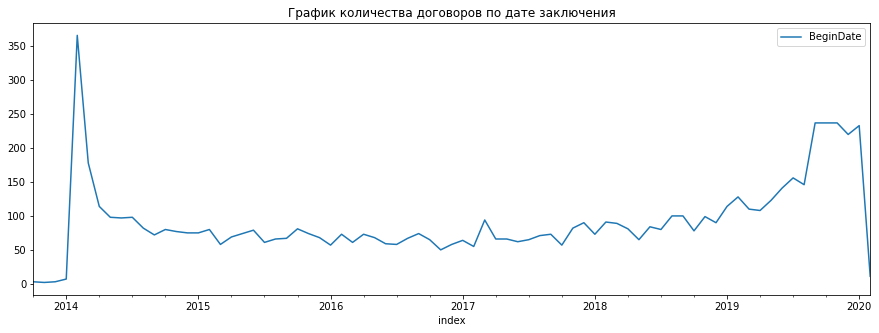

In [42]:
# Построим график количества договоров по дате заключения
begin = df['BeginDate']\
.value_counts()\
.reset_index()\
.sort_values(by='index')


begin.plot(x='index', figsize = (15,5), title='График количества договоров по дате заключения');

Пик заключенных договоров приходится на 2014 год, затем график выходит на плато с небольшими локальными пиками. В 2019 количество договоров начинает расти.

In [43]:
df['BeginDate'].describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: BeginDate, dtype: object

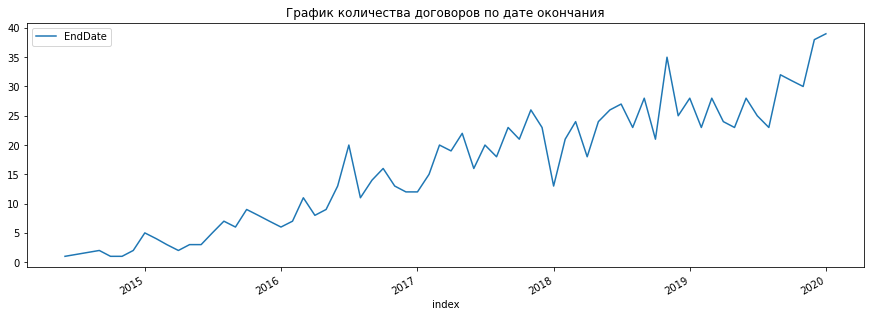

In [44]:
# Построим график количества договоров по по дате окончания
end = df.loc[df['EndDate'] != '2020-02-01']['EndDate']\
.value_counts()\
.reset_index()\
.sort_values(by='index')\

end.plot(x='index', figsize = (15,5), title='График количества договоров по дате окончания');

С каждым годом количество прекращенных договоров растет.

In [45]:
df['EndDate'].describe()

count                    7043
unique                     67
top       2020-02-01 00:00:00
freq                     5942
first     2014-06-01 00:00:00
last      2020-02-01 00:00:00
Name: EndDate, dtype: object

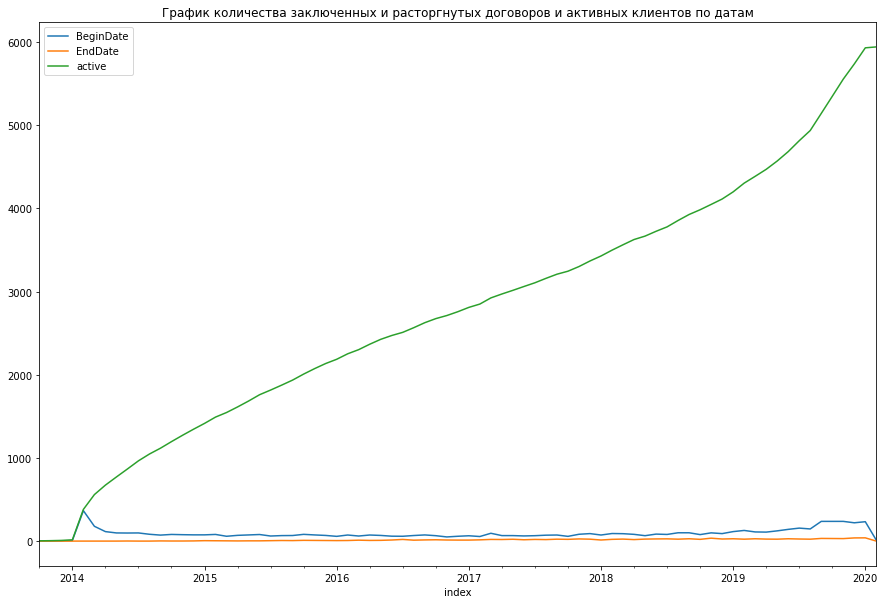

In [46]:
# Совместим два графика и добавим количество действующих клиентов в конкретный момемент времени
bend = begin.merge(end, on='index', how='outer')
bend = bend.fillna(0)
bend['active'] = bend['BeginDate'] - bend['EndDate']
bend['active'] = bend['active'].cumsum()
bend.plot(x='index', 
          figsize = (15,10), 
          title='График количества заключенных и расторгнутых договоров и активных клиентов по датам');

Отток и приток клиентов не так заметны на фоне количества активных клиентов, которое неизменно растет.

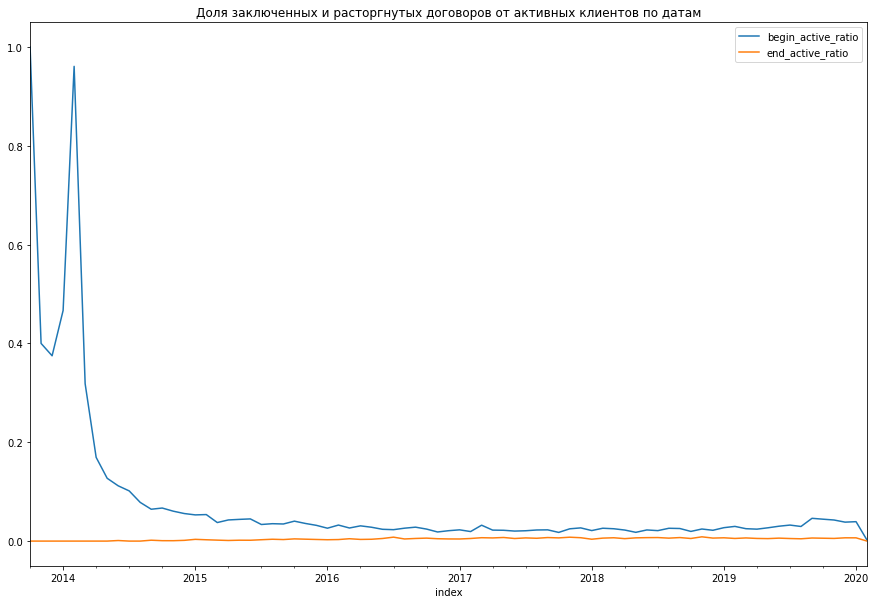

In [47]:
bend['begin_active_ratio'] = bend['BeginDate']/bend['active']
bend['end_active_ratio'] = bend['EndDate']/bend['active']
bend[['index', 'begin_active_ratio', 'end_active_ratio']].plot(x='index', 
          figsize = (15,10),                                                    
          title='Доля заключенных и расторгнутых договоров от активных клиентов по датам');

Доля расторгнутых договоров от активных клиентов почти нулевая и почти не меняется. При этом доля заключенных договоров стабильно больше и в последнее время подросла.

На основе информации о датах начала и заверешния договоров создадим новый признак - длительность договора.

In [48]:
df['contract_duration'] = (df['EndDate'] - df['BeginDate'])
df['contract_duration'] = df['contract_duration'].dt.days

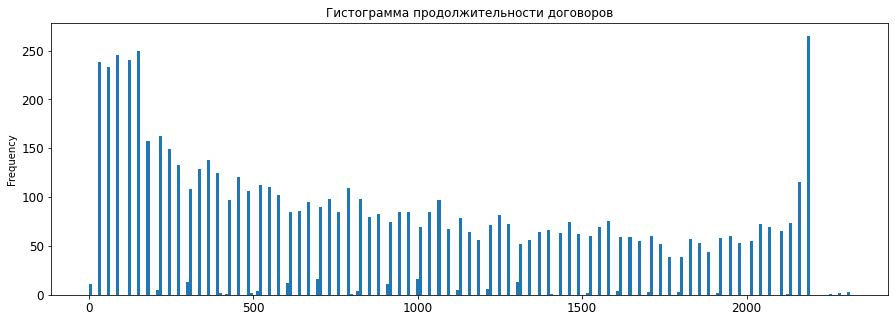

In [49]:
df['contract_duration'].plot(kind='hist', 
                             bins=251,  
                             figsize=(15,5), 
                             fontsize = 12,
                             title='Гистограмма продолжительности договоров');

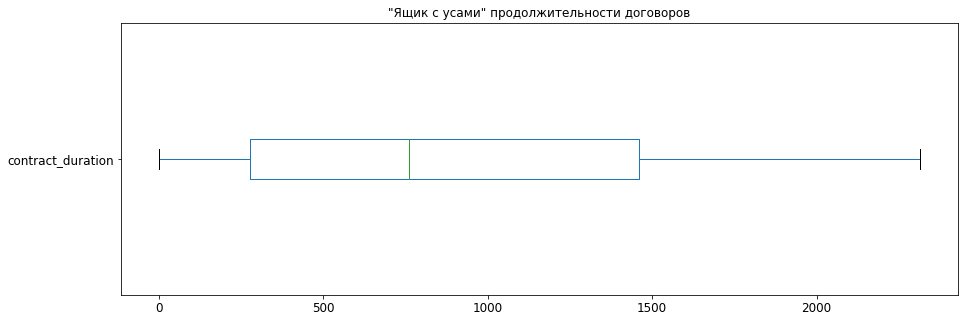

In [50]:
df['contract_duration'].plot.box(vert = False,
                             figsize=(15,5), 
                             fontsize = 12,
                             title='"Ящик с усами" продолжительности договоров');

In [51]:
df['contract_duration'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: contract_duration, dtype: float64

Распределение не нормальное, выбросов нет, но есть пик в районе **2200** дней. 

Средняя продолжительность - **898** дней, медианная - **761**.

### Портрет пользователя

#### Договор

##### Продолжительсть

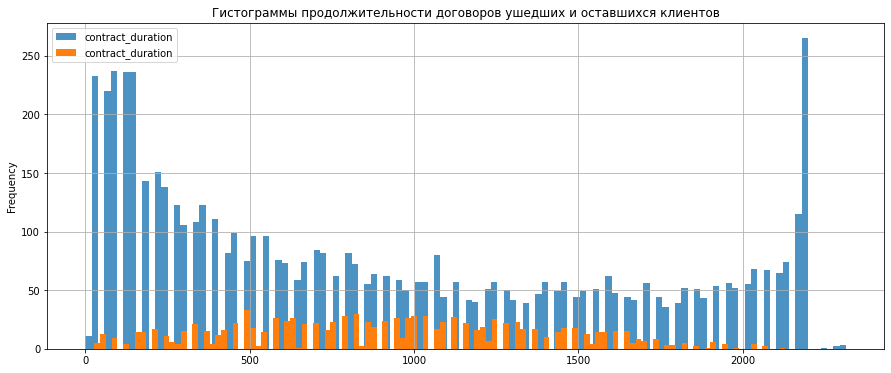

In [52]:
df.loc[df['churn'] == 0]['contract_duration'].plot(kind = 'hist',
      linewidth = 5,
      alpha = 0.8,
      figsize = (15,6), 
      bins = 120, 
      grid = True, 
      legend = True)

df.loc[df['churn'] == 1]['contract_duration'].plot(kind = 'hist',
      linewidth = 5,
      alpha = 1,
      figsize = (15,6), 
      bins = 120, 
      grid = True, 
      legend = True,                                             
      title =\
      'Гистограммы продолжительности договоров ушедших и оставшихся клиентов');

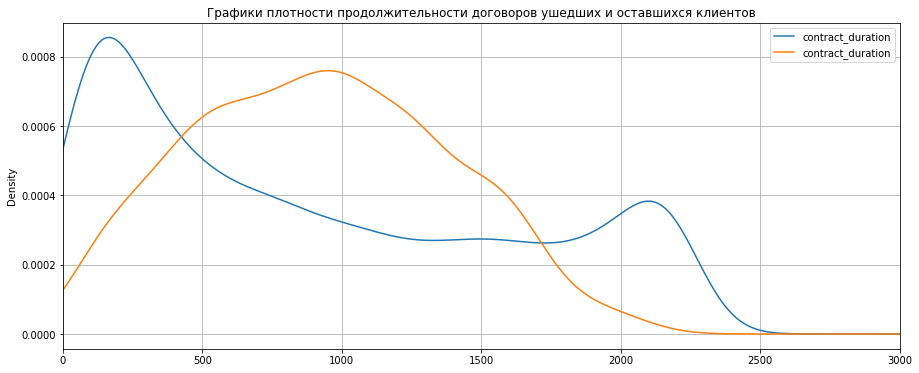

In [53]:
df.loc[df['churn'] == 0]['contract_duration'].plot.density(
      figsize = (15,6),
      xlim = (0, 3000),
      grid = True, 
      legend = True)

df.loc[df['churn'] == 1]['contract_duration'].plot.density(
      grid = True, 
      legend = True,                                             
      title =\
      'Графики плотности продолжительности договоров ушедших и оставшихся клиентов');

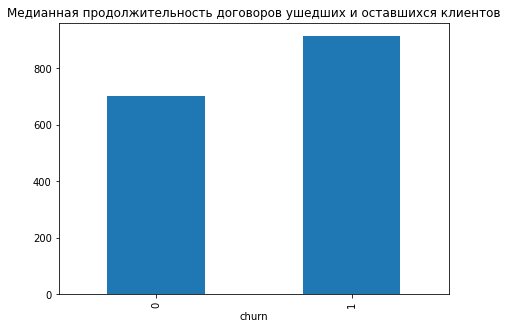

In [54]:
df.groupby('churn')['contract_duration']\
  .median()\
  .plot(kind = 'bar',
        figsize=(7,5),
        title ='Медианная продолжительность договоров ушедших и оставшихся клиентов');

In [55]:
df.loc[df['churn'] == 0]['contract_duration'].describe()

count    5942.000000
mean      893.681084
std       716.958551
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: contract_duration, dtype: float64

In [56]:
df.loc[df['churn'] == 1]['contract_duration'].describe()

count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: contract_duration, dtype: float64

У оставшихся клиентов средняя и медианная продолжительность договора меньше, чем у ушедших. 

В среднем клиенты уходят через **2.5** года. Но как видно на графике плотности, после этого отток идет а спад, а после **5.5** лет клиенты совсем перестают уходить.

##### Траты

**Ежемесячные траты**

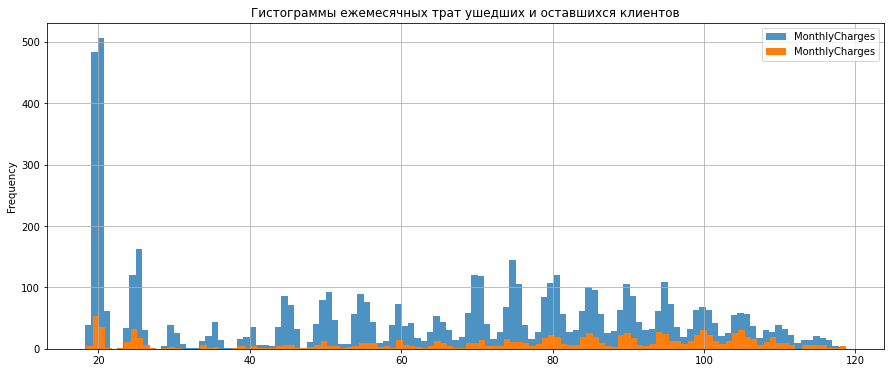

In [57]:
df.loc[df['churn'] == 0]['MonthlyCharges'].plot(kind = 'hist',
      linewidth = 5,
      alpha = 0.8,
      figsize = (15,6), 
      bins = 120, 
      grid = True, 
      legend = True)

df.loc[df['churn'] == 1]['MonthlyCharges'].plot(kind = 'hist',
      linewidth = 5,
      alpha = 1,
      figsize = (15,6), 
      bins = 120, 
      grid = True, 
      legend = True,                                             
      title =\
      'Гистограммы ежемесячных трат ушедших и оставшихся клиентов');

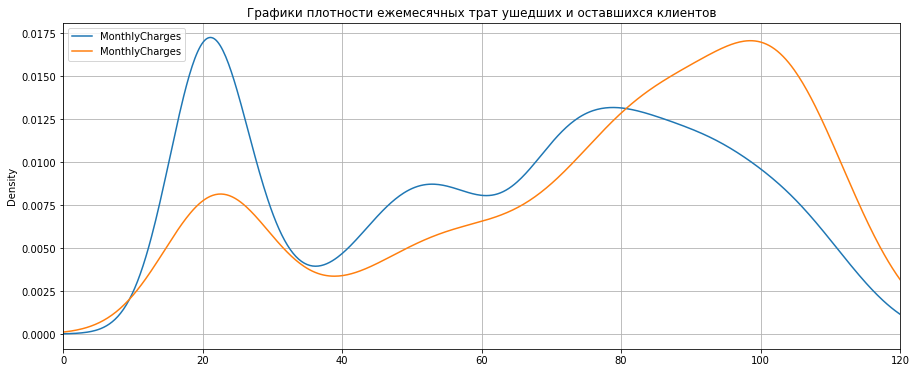

In [58]:
df.loc[df['churn'] == 0]['MonthlyCharges'].plot.density(
      figsize = (15,6),
      xlim = (0, 120),
      grid = True, 
      legend = True)

df.loc[df['churn'] == 1]['MonthlyCharges'].plot.density(
      grid = True, 
      legend = True,                                             
      title =\
      'Графики плотности ежемесячных трат ушедших и оставшихся клиентов');

In [59]:
df['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [60]:
df.loc[df['churn'] == 0]['MonthlyCharges'].describe()

count    5942.000000
mean       62.763455
std        29.844462
min        18.250000
25%        30.062500
50%        69.200000
75%        87.237500
max       118.600000
Name: MonthlyCharges, dtype: float64

In [61]:
df.loc[df['churn'] == 1]['MonthlyCharges'].describe()

count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: MonthlyCharges, dtype: float64

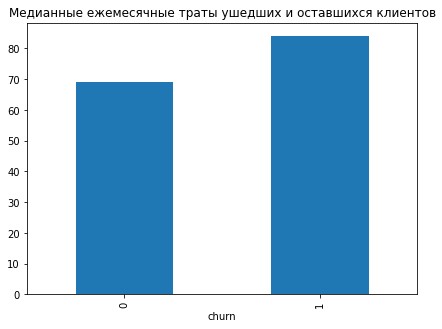

In [62]:
df.groupby('churn')['MonthlyCharges']\
  .median()\
  .plot(kind = 'bar',
        figsize=(7,5),
        title ='Медианные ежемесячные траты ушедших и оставшихся клиентов');

Распределения ежемесячных трат похожи, но ушедшие клиенты в среднем тратят больше оставшихся.

**Общие траты**

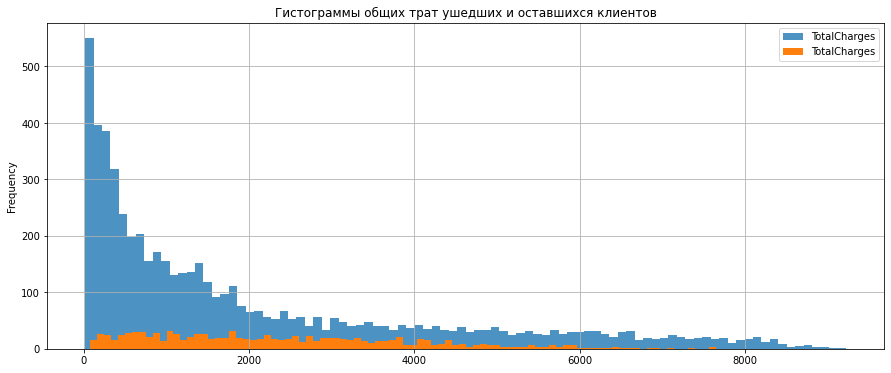

In [63]:
ax = df.loc[df['churn'] == 0]['TotalCharges'].plot(kind = 'hist',
      linewidth = 5,
      alpha = 0.8,
      figsize = (15,6), 
      bins = 90, 
      grid = True, 
      legend = True,
      title =\
      'Гистограммы общих трат ушедших и оставшихся клиентов');

df.loc[df['churn'] == 1]['TotalCharges'].plot(kind = 'hist',
      linewidth = 5,
      alpha = 1,
      figsize = (15,6), 
      bins = 90, 
      grid = True, 
      legend = True,
      ax = ax);

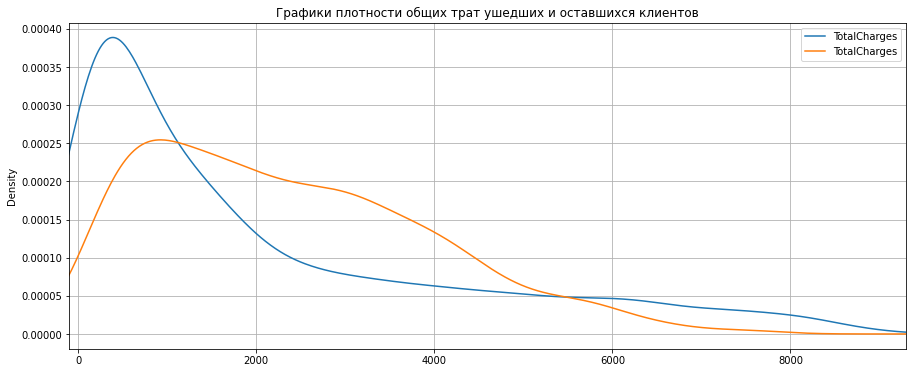

In [64]:
df.loc[df['churn'] == 0]['TotalCharges'].plot.density(
      figsize = (15,6),
      xlim = (-100, 9300),
      grid = True, 
      legend = True)

df.loc[df['churn'] == 1]['TotalCharges'].plot.density(
      grid = True, 
      legend = True,                                             
      title =\
      'Графики плотности общих трат ушедших и оставшихся клиентов');

In [65]:
df['TotalCharges'].describe()

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

In [66]:
df.loc[df['churn'] == 0]['TotalCharges'].describe()

count    5942.000000
mean     2067.943095
std      2193.827140
min        19.050000
25%       374.352500
50%      1192.800000
75%      3173.837500
max      9221.380000
Name: TotalCharges, dtype: float64

In [67]:
df.loc[df['churn'] == 1]['TotalCharges'].describe()

count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: TotalCharges, dtype: float64

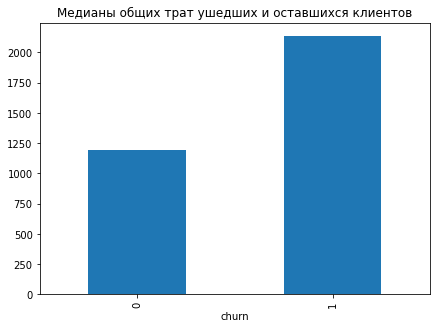

In [68]:
df.groupby('churn')['TotalCharges']\
  .median()\
  .plot(kind = 'bar',
        figsize=(7,5),
        title ='Медианы общих трат ушедших и оставшихся клиентов');

Общие траты ушедших клиентов также ожидаемо превышают тарты оставшихся. 

Средние тарты не так сильно различаются, а вот медианные в **1.8** раза. Компания теряет платежеспособных клиентов.

##### Параметры договора

In [69]:
titles = ['Тип договора', 'Электронное выставление счетов', 'Способ оплаты']

names = ['Type', 'PaperlessBilling', 'PaymentMethod']

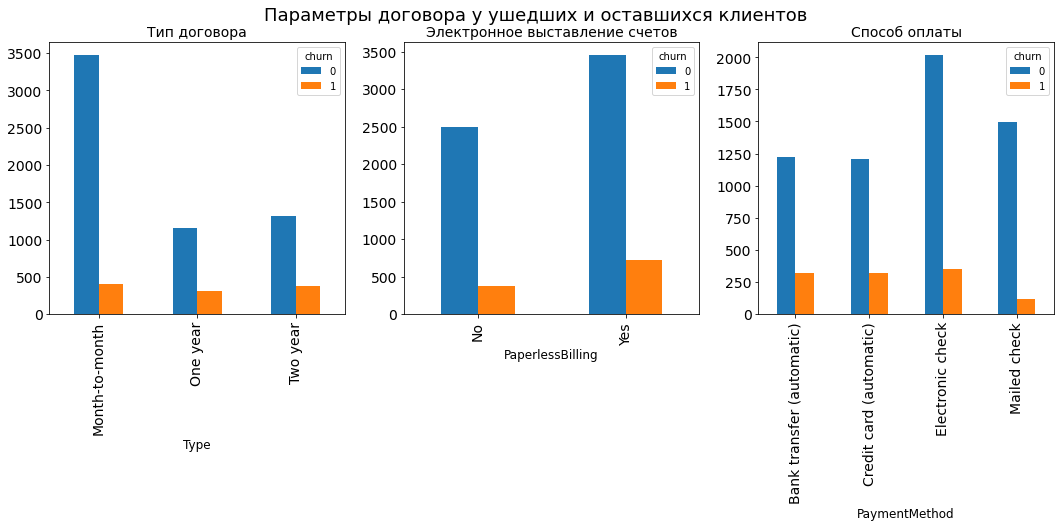

In [70]:

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5), sharex = False, sharey = False)

for i in range(3):
    pd.crosstab(df[names[i]], df['churn']).plot(kind='bar', ax=axes[i], fontsize=14)
    axes[i].set_xlabel(names[i], fontsize=12)
    axes[i].set_title(titles[i],  fontsize = 14)
    
fig.suptitle('Параметры договора у ушедших и оставшихся клиентов', fontsize = 18)   


plt.show()

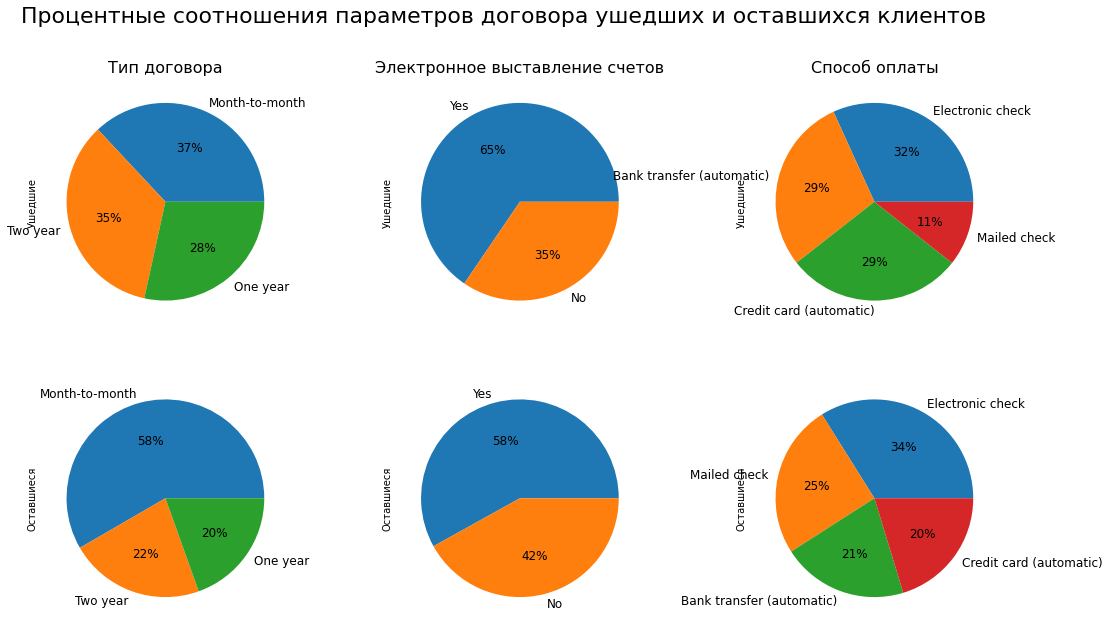

In [71]:
plt.figure(figsize=[18, 10])

plt.suptitle('Процентные соотношения параметров договора ушедших и оставшихся клиентов', fontsize = 22)  

nums = [1, 2, 3]

for i in range(3):
    globals()['s' + str(i)] = plt.subplot(2, 3, nums[i])
    
    df.loc[df['churn'] == 1, names[i]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Ушедшие',
                                                           fontsize=12);
    
    plt.title(titles[i],  fontsize = 16)
    
nums2 = [4, 5, 6]

for i in range(3):
    globals()['s' + str([i+3])] = plt.subplot(2, 3, nums2[i])
    
    df.loc[df['churn'] == 0, names[i]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Оставшиеся',
                                                           fontsize=12);

Оставшиеся пользватели предпочитают, помесячные контракты, в то время как у ушедших типы контрактов распределены примерно в равных долях. 

Ушедшие клиенты больше пердпочитают электронное выставление счетов и электронные способы оплаты. 

#### Личные данные

In [72]:
titles = ['Пол', 'Пенсионный статус', 'Наличие супруга(и)', 'Иждивенцы']

names = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

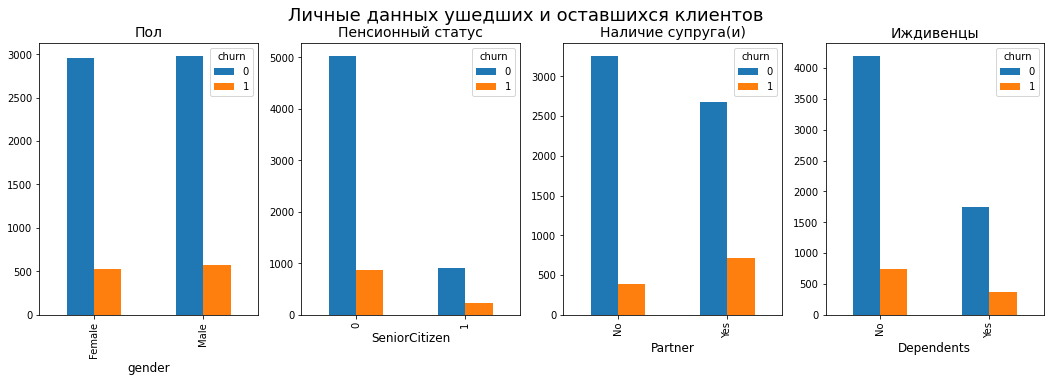

In [73]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (18,5), sharex = False, sharey = False)

for i in range(4):
    pd.crosstab(df[names[i]], df['churn']).plot(kind='bar', ax=axes[i])
    axes[i].set_xlabel(names[i], fontsize=12)
    axes[i].set_title(titles[i],  fontsize = 14)
    
fig.suptitle('Личные данных ушедших и оставшихся клиентов', fontsize = 18)   


plt.show();

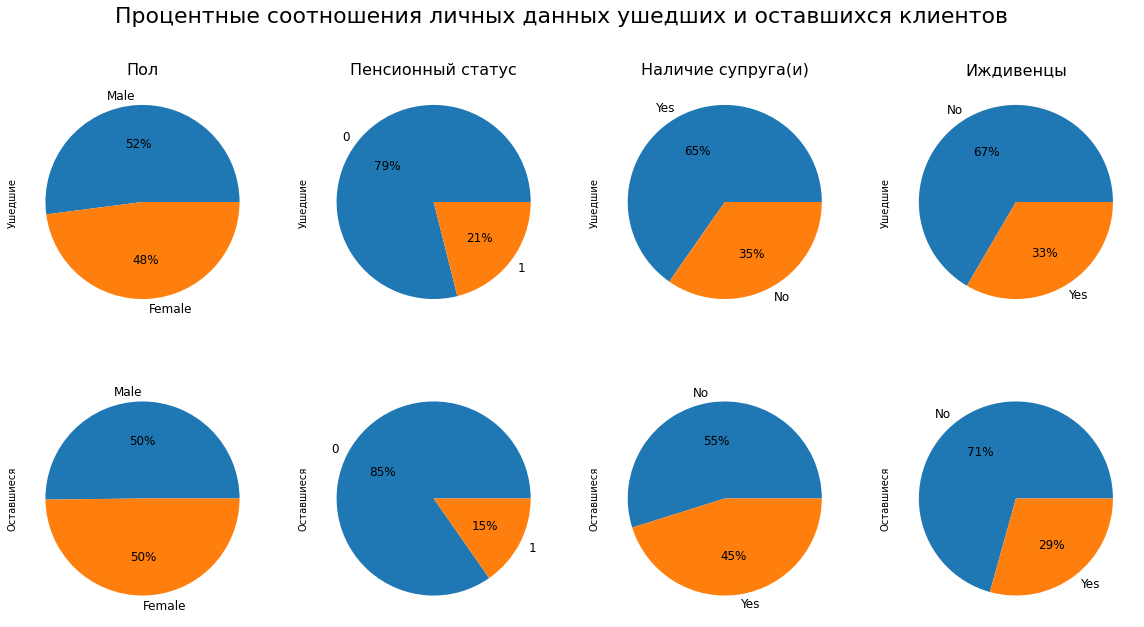

In [74]:
plt.figure(figsize=[20, 10])

plt.suptitle('Процентные соотношения личных данных ушедших и оставшихся клиентов', fontsize = 22)  

nums = [1, 2, 3, 4]

for i in range(4):
    globals()['s' + str(i)] = plt.subplot(2, 4, nums[i])
    
    df.loc[df['churn'] == 1, names[i]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Ушедшие',
                                                           fontsize=12);
    
    plt.title(titles[i],  fontsize = 16)
    
nums2 = [5, 6, 7, 8]

for i in range(4):
    globals()['s' + str([i+3])] = plt.subplot(2, 4, nums2[i])
    
    df.loc[df['churn'] == 0, names[i]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Оставшиеся',
                                                           fontsize=12);

Среди ушедших чуть больше пенсионеров и намного больше состоящих в браке.

#### Основые услуги

In [75]:
titles = ['Телефония', 'Интернет']

names = ['PhoneLines', 'InternetService']

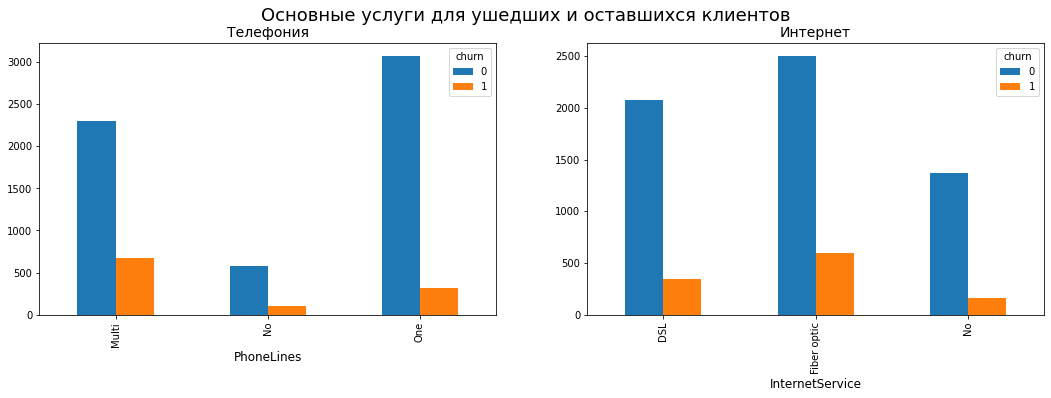

In [76]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18,5), sharex = False, sharey = False)

for i in range(2):
    pd.crosstab(df[names[i]], df['churn']).plot(kind='bar', ax=axes[i])
    axes[i].set_xlabel(names[i], fontsize=12)
    axes[i].set_title(titles[i],  fontsize = 14)
    
fig.suptitle('Основные услуги для ушедших и оставшихся клиентов', fontsize = 18)   


plt.show()

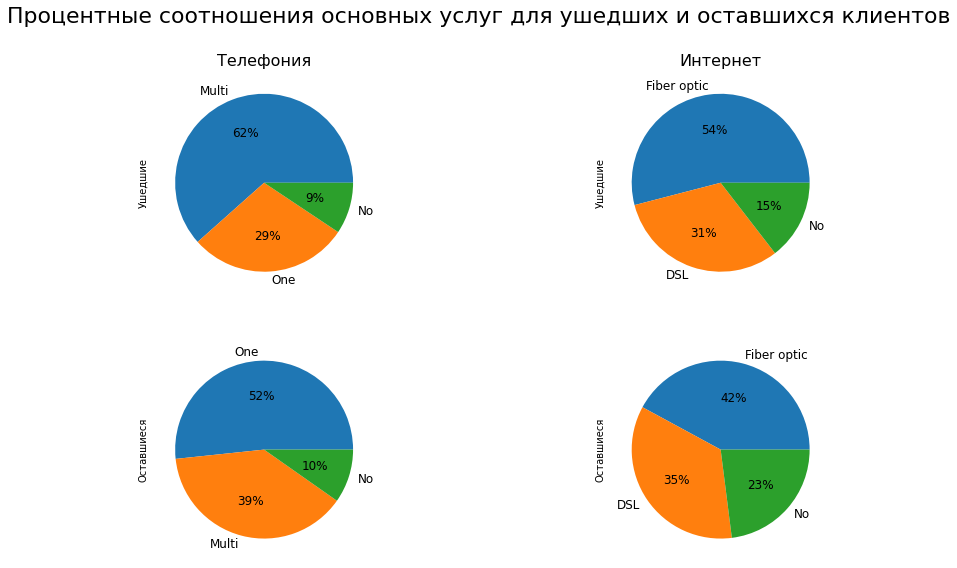

In [77]:
plt.figure(figsize=[15, 9])

plt.suptitle('Процентные соотношения основных услуг для ушедших и оставшихся клиентов', fontsize = 22)  

nums = [1, 2]

for i in range(2):
    globals()['s' + str(i)] = plt.subplot(2, 2, nums[i])
    
    df.loc[df['churn'] == 1, names[i]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Ушедшие',
                                                           fontsize=12);
    
    plt.title(titles[i],  fontsize = 16)
    
nums2 = [3, 4]

for i in range(2):
    globals()['s' + str([i+3])] = plt.subplot(2, 2, nums2[i])
    
    df.loc[df['churn'] == 0, names[i]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Оставшиеся',
                                                           fontsize=12);

Среди ушедших клиентов больше пользователей интернета. При этом они предпочитают оптоволокно. И несколько линий телефонной связи.

#### Дополнительные услуги

In [78]:
titles = ['Онлайн безопасность', 'Облако', 'Антивирус', 'Техподдержка', 'ТВ', 'Фильмы']

names = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
         'StreamingMovies']

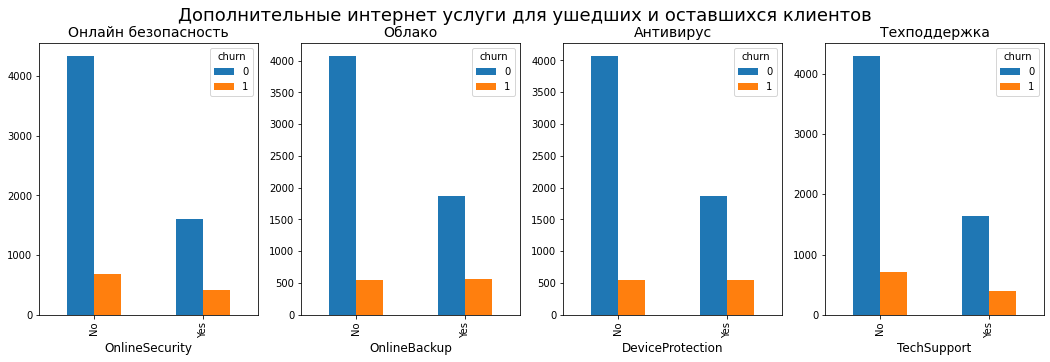

In [79]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (18,5), sharex = False, sharey = False)

for i in range(4):
    pd.crosstab(df[names[i]], df['churn']).plot(kind='bar', ax=axes[i])
    axes[i].set_xlabel(names[i], fontsize=12)
    axes[i].set_title(titles[i],  fontsize = 14)
    
fig.suptitle('Дополнительные интернет услуги для ушедших и оставшихся клиентов', fontsize = 18)   


plt.show();

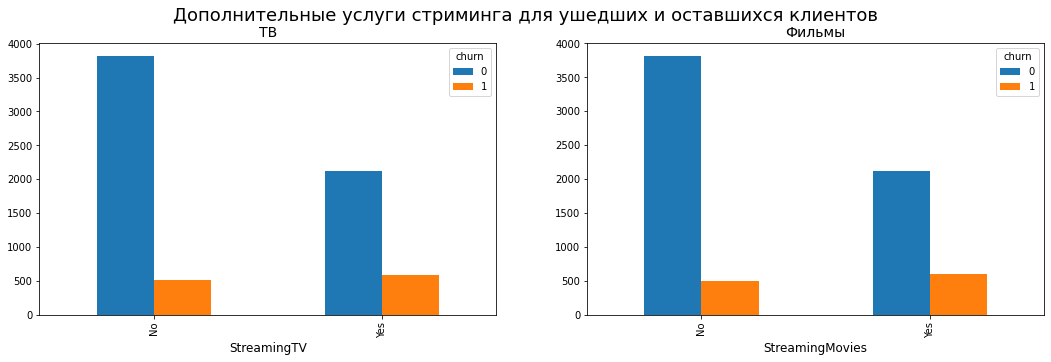

In [80]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18,5), sharex = False, sharey = False)

for i in range(2):
    pd.crosstab(df[names[i+4]], df['churn']).plot(kind='bar', ax=axes[i])
    axes[i].set_xlabel(names[i+4], fontsize=12)
    axes[i].set_title(titles[i+4],  fontsize = 14)
    
fig.suptitle('Дополнительные услуги стриминга для ушедших и оставшихся клиентов', fontsize = 18)   


plt.show();

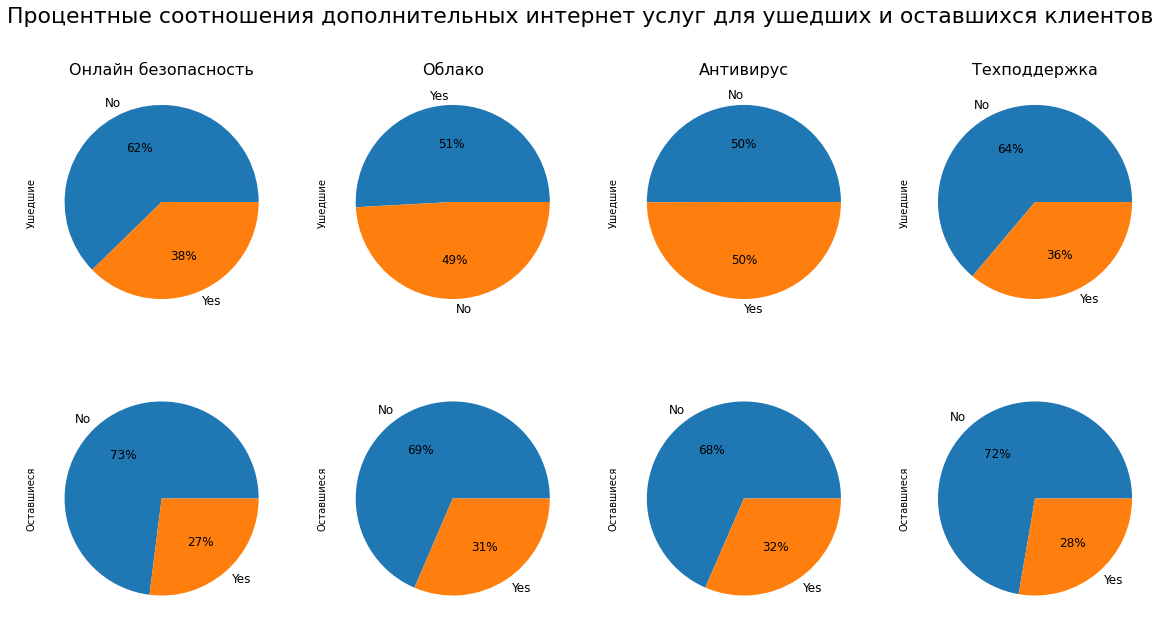

In [81]:
plt.figure(figsize=[20, 10])

plt.suptitle('Процентные соотношения дополнительных интернет услуг для ушедших и оставшихся клиентов', fontsize = 22)  

nums = [1, 2, 3, 4]

for i in range(4):
    globals()['s' + str(i)] = plt.subplot(2, 4, nums[i])
    
    df.loc[df['churn'] == 1, names[i]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Ушедшие',
                                                           fontsize=12);
    
    plt.title(titles[i],  fontsize = 16)
    
nums2 = [5, 6, 7, 8]

for i in range(4):
    globals()['s' + str([i+3])] = plt.subplot(2, 4, nums2[i])
    
    df.loc[df['churn'] == 0, names[i]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Оставшиеся',
                                                           fontsize=12);

Ушедшие клиенты больше пользуются дополнительными интернет-услугами.

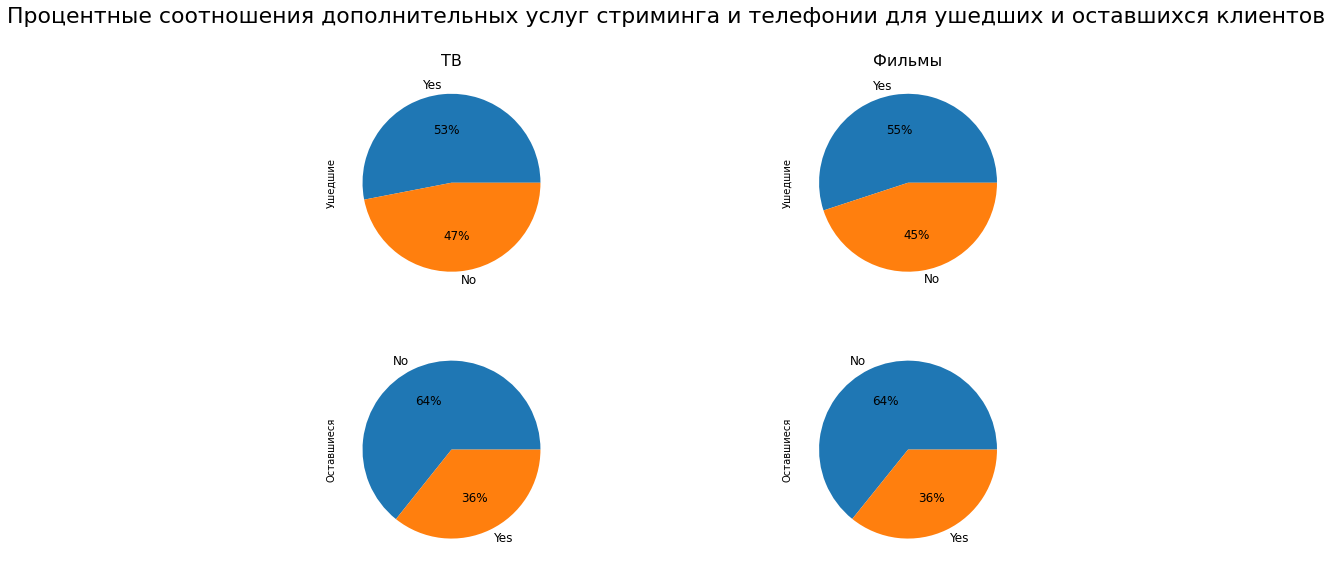

In [82]:
plt.figure(figsize=[15, 9])

plt.suptitle(
    'Процентные соотношения дополнительных услуг стриминга и телефонии для ушедших и оставшихся клиентов', 
    fontsize = 22
)  

nums = [1, 2]

for i in range(2):
    globals()['s' + str(i)] = plt.subplot(2, 2, nums[i])
    
    df.loc[df['churn'] == 1, names[i+4]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Ушедшие',
                                                           fontsize=12);
    
    plt.title(titles[i+4],  fontsize = 16)
    
nums2 = [3, 4]

for i in range(2):
    globals()['s' + str([i+2])] = plt.subplot(2, 2, nums2[i])
    
    df.loc[df['churn'] == 0, names[i+4]].value_counts().plot(kind='pie', 
                                                           autopct = '%.0f%%', 
                                                           ylabel='Оставшиеся',
                                                           fontsize=12);

И стиминговыми услугами ушедшие тоже пользуются чаще.

**Вывод**

От оператора связи уходят лучшие клиенты. 

Они дольше пользуются услугами компании, больше платят, подключают дополнительные услуги. Это сосотявшиеся, в основном семейные люди, предпочитающие современные экологичные способы оплаты. 

Отток растет. Максимум приходится на период  2 - 3 года с момента заключения договора. 

В то же время на фоне постоянно растущего количества активных клиентов доля ушедших близка к нулю. 

### Мультиколлинеарность 

In [83]:
interval_cols = ['MonthlyCharges', 'TotalCharges']    

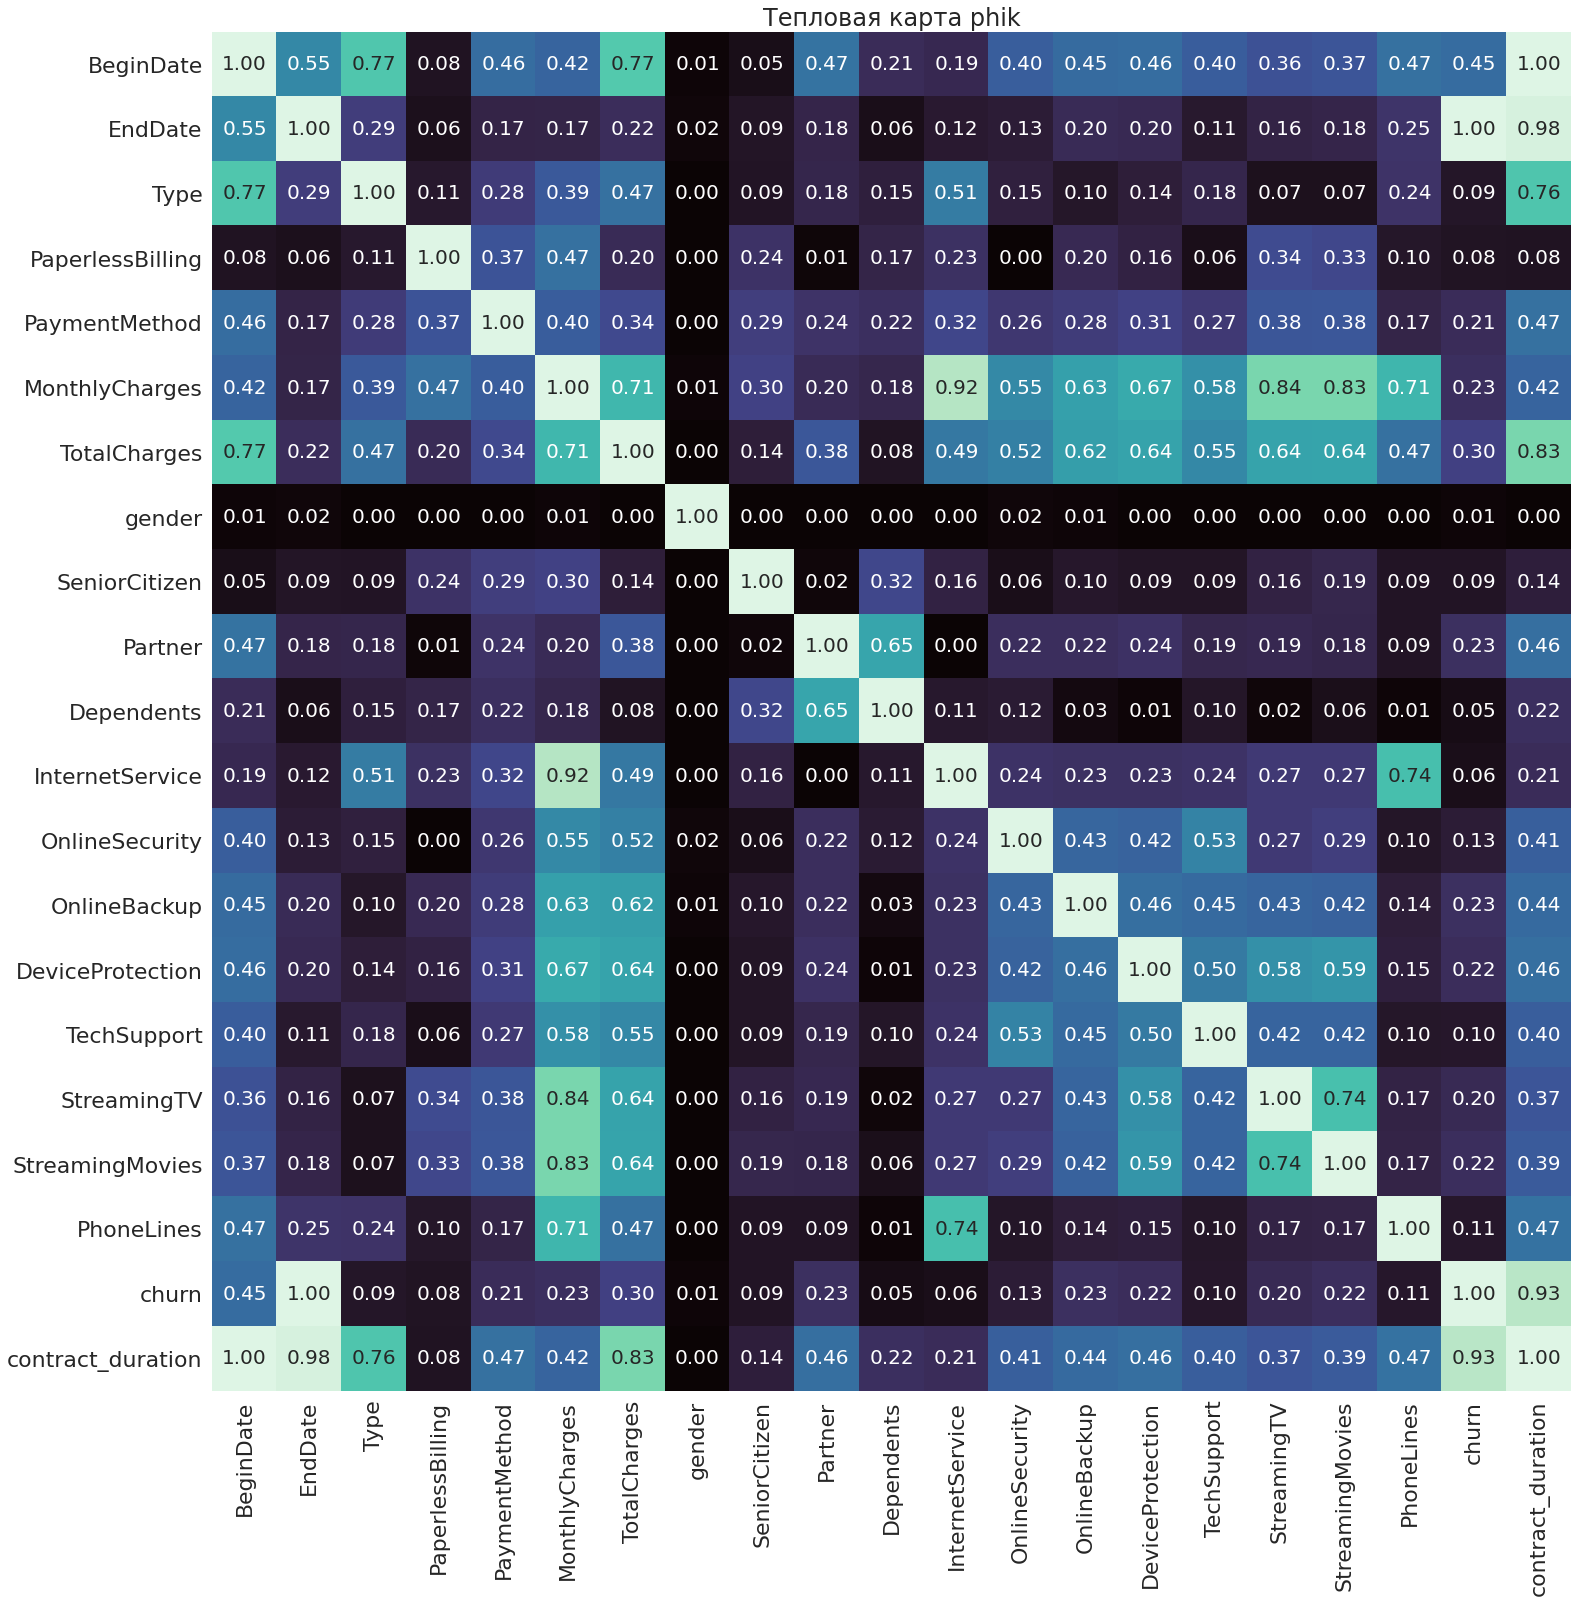

In [84]:
# Построим хитмэп корреляций phik

plt.figure(figsize = (25,25))

sns.set(font_scale = 2)

sns.heatmap(df.phik_matrix(interval_cols=interval_cols), 
            square=True,
            cbar=False,
            annot=True, 
            annot_kws={'size':20},
            cmap = 'mako', 
            fmt = '.2f')

plt.title('Тепловая карта phik', fontsize = 24)

plt.show()

**Корреляции с целевым признаком**

Как мы уже увидели в ходе анализа, продолжительность контракта очень сильно связана с оттоком. На втором месте с большим отрывом - дата заключения договор, на третьем - общие траты.

Пол, наличие иждивенцев и пенсионного статуса, интернет, электронные счета и тип договора почти не коррелируют с оттоком. Использование услуг телефонии и дополнительные интернет-услуги  - техподдежка и онлайн безопасность коррелируют слабо. 

Чуть сильнее - стриминговые услуги, антивирус и облачное хранилище, наличие партнера.

**Коррелиции признаков между собой**

Ежемесяные траты сильно коррелируют с услугами интренета, телефонии и стриминга, а общие траты с продолжительностью контракта и датой заключения, что ожидаемо. Также с продолжительностью и датой заключения коррелирует тип договора. 

Стримиг фильмов и ТВ коррелируют между собой, очевидно клиенты подключают их вместе. В целом дополнительные услуги достаточно сильно связаны с тратами, что также вполне очевидно.

## Подготовка признаков

### Выбор признаков для обучения модели

Выявленная мультиколлинеарность может осложнить работу линейной модели. С этим справится регуляризация. Для "деревянных" моделей, в том числе градиентных бустингов она не старшна. Но большое количество признаков может привести к переобучению. 

Для начала удалим признаки, которые сильно коррелируют с тратами и при этом почти не влияют на целевой: тип договора и интернет. Удалим другие признаки, которые почти не связяны с целевым: пол, наличие иждивенцев и пенсионного статуса. 

Кроме того, среди признаков есть те, которые содержат утечку целевого признака, например, дата начала и окончания договора. Поэтому мы оставим только длительность.

In [85]:
df_prep = df.drop(['Type',
                   'gender',
                   'Dependents',
                   'SeniorCitizen',
                   'InternetService',
                   'BeginDate',
                   'EndDate'],
                    axis=1)

In [86]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PaperlessBilling   7043 non-null   object 
 1   PaymentMethod      7043 non-null   object 
 2   MonthlyCharges     7043 non-null   float64
 3   TotalCharges       7043 non-null   float64
 4   Partner            7043 non-null   object 
 5   OnlineSecurity     7043 non-null   object 
 6   OnlineBackup       7043 non-null   object 
 7   DeviceProtection   7043 non-null   object 
 8   TechSupport        7043 non-null   object 
 9   StreamingTV        7043 non-null   object 
 10  StreamingMovies    7043 non-null   object 
 11  PhoneLines         7043 non-null   object 
 12  churn              7043 non-null   int64  
 13  contract_duration  7043 non-null   int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 1.1+ MB


### Деление данных на выборки

In [87]:
RANDOM_STATE = 220523

In [88]:
# Разделим на выборки
features_train, features_test, target_train, target_test =\
train_test_split(df_prep.drop(['churn'], axis=1), 
                 df_prep.churn, 
                 test_size=0.25, 
                 random_state=RANDOM_STATE)

### Трансформация признаков

In [89]:
# Сохраним категориальные признаки в отдельную переменную
cat_features = ['PaperlessBilling', 
                'PaymentMethod', 
                'Partner', 
                'OnlineSecurity', 
                'OnlineBackup', 
                'DeviceProtection',
                'TechSupport',
                'StreamingTV',
                'StreamingMovies',
                'PhoneLines']

In [90]:
# Обозначим численные признаки
num_features = ['MonthlyCharges', 'TotalCharges', 'contract_duration']

In [91]:
# Изменим тип данных категориальных признаков на 'category' для LGBMClassifier
lgbm_features_train = features_train.copy()
lgbm_features_test = features_test.copy()

for col in lgbm_features_train.select_dtypes(include=['object']):
    lgbm_features_train[col] = lgbm_features_train[col].astype('category') 
    
for col in lgbm_features_test.select_dtypes(include=['object']):
    lgbm_features_test[col] = lgbm_features_test[col].astype('category')     

In [92]:
# Закодируем категориальные признаки с помощью OneHotEncoder
# и масштабируем числовые признаки с помощью StandardScaler, поместим оба действия в ColumnTransformer
scaler = StandardScaler()
    
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
    
preprocessing = ColumnTransformer([('num', scaler, num_features), ('cat', encoder, cat_features)])

## Обучение моделей

### Логистическая регрессия

In [93]:
# Инициализируем модель логистической регрессии, 
# настроим гиперпараметры с помощью optuna,
# поместим трансформацию признаков в Pipeline
# и проверим качество модели на кросс-валидации с помощью cross_validate

def objective(trial):
    max_iter = trial.suggest_int('max_iter', 500, 1500, 500)
    C = trial.suggest_categorical('C', [0.01, 0.1, 1.0, 10.0])
    l1_ratio = trial.suggest_categorical('l1_ratio', [0, 0.2, 0.5, 0.8, 1])
    
    
    lr = LogisticRegression(max_iter=max_iter,
                               C=C,
                               l1_ratio = l1_ratio,
                               solver='saga',
                               class_weight = 'balanced',
                               random_state=RANDOM_STATE)
    
    pipe = Pipeline(steps=[('preprocess', preprocessing), ('model', lr)])  
    
    cv = cross_validate(pipe, 
                        features_train,  
                        target_train,
                        n_jobs = -1, 
                        cv = 5, 
                        scoring = ['roc_auc', 'accuracy'],
                        error_score='raise')
    
    print('accuracy:')
    print(cv['test_accuracy'].mean())
    
    return cv['test_roc_auc'].mean()

study = optuna.create_study(direction ='maximize')
study.optimize(objective, n_trials = 5, show_progress_bar = True)

lr_iter = study.best_trial.params.get('max_iter')
lr_C = study.best_trial.params.get('C')
lr_l1_ratio = study.best_trial.params.get('l1_ratio')
lr_score = study.best_value

lr = LogisticRegression(max_iter=lr_iter,
                        C=lr_C,
                        l1_ratio=lr_l1_ratio,
                        class_weight = 'balanced',
                        random_state=RANDOM_STATE)

[I 2023-05-29 05:23:48,714] A new study created in memory with name: no-name-91db6019-5796-4071-afca-62b3d07d8a2a


  0%|          | 0/5 [00:00<?, ?it/s]

accuracy:
0.6590337504658696
[I 2023-05-29 05:23:49,907] Trial 0 finished with value: 0.7191842830842304 and parameters: {'max_iter': 1000, 'C': 0.01, 'l1_ratio': 1}. Best is trial 0 with value: 0.7191842830842304.
accuracy:
0.6851573922765976
[I 2023-05-29 05:23:51,286] Trial 1 finished with value: 0.7253851830543051 and parameters: {'max_iter': 500, 'C': 1.0, 'l1_ratio': 0}. Best is trial 1 with value: 0.7253851830543051.
accuracy:
0.6845890312777729
[I 2023-05-29 05:23:52,688] Trial 2 finished with value: 0.7253238811619289 and parameters: {'max_iter': 500, 'C': 10.0, 'l1_ratio': 0.2}. Best is trial 1 with value: 0.7253851830543051.
accuracy:
0.6845890312777729
[I 2023-05-29 05:23:54,286] Trial 3 finished with value: 0.7253238811619289 and parameters: {'max_iter': 500, 'C': 10.0, 'l1_ratio': 0.8}. Best is trial 1 with value: 0.7253851830543051.
accuracy:
0.6590337504658696
[I 2023-05-29 05:23:55,415] Trial 4 finished with value: 0.7191842830842304 and parameters: {'max_iter': 1000, 

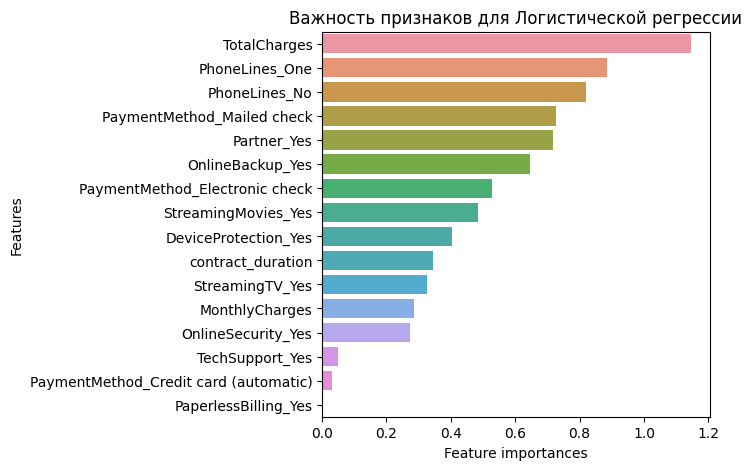

In [95]:
# Посмотрим на важность признаков для Логистической регрессии 

pipe = Pipeline(steps=[('preprocess', preprocessing), ('lr', lr)])  

pipe.fit(features_train, target_train)

# определим новые названия признаков после трансформации:
cat_cols_new = [f.replace(f.split('_')[0], 
                cat_features[int(f.split('_')[0][1:])]) 
                for f in pipe['preprocess'].named_transformers_['cat'].get_feature_names()]
all_cols = np.concatenate([num_features, cat_cols_new])

for_feat_imp = pd.Series(np.abs(lr.coef_[0]), index=all_cols).sort_values(ascending=False)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.subplots(figsize=(5, 5)) 
ax = sns.barplot(x=for_feat_imp, y=for_feat_imp.index) 
ax.set_title('Важность признаков для Логистической регрессии') 
ax.set_yticklabels(for_feat_imp.index) 
ax.set_xlabel('Feature importances') 
ax.set_ylabel('Features') 
plt.show()

### Случайый лес

In [96]:
# Инициализируем модель случайного леса, 
# настроим гиперпараметры с помощью optuna,
# поместим трансформацию признаков в Pipeline
# и проверим качество модели на кросс-валидации с помощью cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 20, 2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, 2)
    n_estimators = trial.suggest_int('n_estimators', 10, 50, 10)
    
    model = RandomForestClassifier(max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  n_estimators=n_estimators, 
                                  class_weight='balanced',
                                  random_state=RANDOM_STATE)
    
    pipe = Pipeline(steps=[('preprocess', preprocessing), ('model', model)])  
    
    cv = cross_validate(pipe, 
                        features_train,  
                        target_train,
                        n_jobs = -1, 
                        cv = 5, 
                        scoring = ['roc_auc', 'accuracy'],
                        error_score='raise')
    
    print('accuracy:')
    print(cv['test_accuracy'].mean())
    
    return cv['test_roc_auc'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 5, show_progress_bar=True)

for_depth = study.best_trial.params.get('max_depth')
for_smpls = study.best_trial.params.get('min_samples_split')
for_estms = study.best_trial.params.get('n_estimators')
for_score = study.best_value

forest = RandomForestClassifier(max_depth=for_depth, 
                                min_samples_split=for_smpls, 
                                n_estimators=for_estms,
                                class_weight='balanced',
                                random_state=RANDOM_STATE)

[I 2023-05-29 05:26:06,300] A new study created in memory with name: no-name-a7ec5d7f-f379-48a9-ab7e-ac927de8adc4


  0%|          | 0/5 [00:00<?, ?it/s]

accuracy:
0.773380565350764
[I 2023-05-29 05:26:07,051] Trial 0 finished with value: 0.7913937102573108 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 30}. Best is trial 0 with value: 0.7913937102573108.
accuracy:
0.6915957111321349
[I 2023-05-29 05:26:07,657] Trial 1 finished with value: 0.7929244773305285 and parameters: {'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 30}. Best is trial 1 with value: 0.7929244773305285.
accuracy:
0.8076479673747887
[I 2023-05-29 05:26:08,449] Trial 2 finished with value: 0.7806339777871761 and parameters: {'max_depth': 15, 'min_samples_split': 12, 'n_estimators': 30}. Best is trial 1 with value: 0.7929244773305285.
accuracy:
0.7951526260715003
[I 2023-05-29 05:26:09,284] Trial 3 finished with value: 0.7906923502370431 and parameters: {'max_depth': 11, 'min_samples_split': 12, 'n_estimators': 30}. Best is trial 1 with value: 0.7929244773305285.
accuracy:
0.7938300937473122
[I 2023-05-29 05:26:09,926] Trial 4 finished

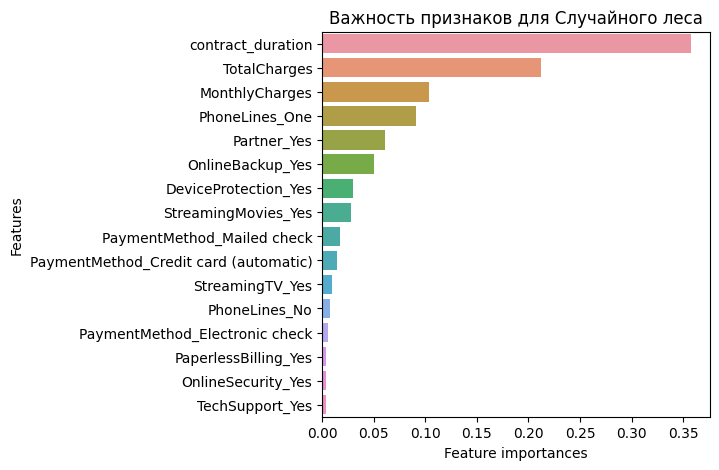

In [97]:
# Посмотрим на важность признаков для Случайного леса 

pipe = Pipeline(steps=[('preprocess', preprocessing), ('forest', forest)])  

pipe.fit(features_train, target_train)

for_feat_imp = pd.Series(forest.feature_importances_, index=all_cols).sort_values(ascending=False)

plt.subplots(figsize=(5, 5)) 
ax = sns.barplot(x=for_feat_imp, y=for_feat_imp.index) 
ax.set_title('Важность признаков для Случайного леса') 
ax.set_yticklabels(for_feat_imp.index) 
ax.set_xlabel('Feature importances') 
ax.set_ylabel('Features') 
plt.show()

### LGBMClassifier

In [98]:
# Инициализируем модель LGBMClassifier, 
# настроим гиперпараметры с помощью optuna,
# поместим трансформацию признаков в Pipeline
# и проверим качество модели на кросс-валидации с помощью cross_validate

%time

def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate',  low=0.03, high=0.1, step=0.07)
    n_estimators = trial.suggest_int('n_estimators', 10, 50, 10)
    
    model = lgb.LGBMClassifier(num_leaves=31,  random_seed=RANDOM_STATE)
    
    cv = cross_validate(model,  
                        lgbm_features_train,  
                        target_train,
                        n_jobs=-1, 
                        cv=5, 
                        scoring=['roc_auc', 'accuracy'],
                        error_score='raise')
    
    
    print('accuracy:')
    print(cv['test_accuracy'].mean())
    
    return cv['test_roc_auc'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 1, show_progress_bar = True)

lgbm_lr=study.best_trial.params.get('learning_rate')
lgbm_estmtrs=study.best_trial.params.get('n_estimators')
lgbm_score = study.best_value

lgbm = lgb.LGBMClassifier(num_leaves=31, 
                         learning_rate=lgbm_lr, 
                         n_estimators=lgbm_estmtrs,
                         random_seed=RANDOM_STATE)

[I 2023-05-29 05:26:21,291] A new study created in memory with name: no-name-9304a1b1-33f8-4774-920e-56fb692c3bbf


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


  0%|          | 0/1 [00:00<?, ?it/s]

accuracy:
0.8765635302886959
[I 2023-05-29 05:26:26,591] Trial 0 finished with value: 0.8489431295406747 and parameters: {'learning_rate': 0.1, 'n_estimators': 10}. Best is trial 0 with value: 0.8489431295406747.


In [99]:
lgbm.fit(lgbm_features_train, target_train)

LGBMClassifier(n_estimators=10, random_seed=220523)

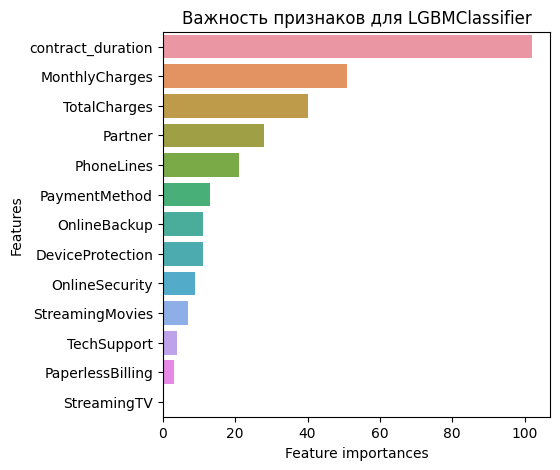

In [100]:
# Посмотрим на важность признаков для LGBMClassifier

lgbm_feat_imp = pd.Series(lgbm.feature_importances_, index=lgbm.feature_name_).sort_values(ascending=False)

plt.subplots(figsize=(5, 5)) 
ax = sns.barplot(x=lgbm_feat_imp, y=lgbm_feat_imp.index) 
ax.set_title('Важность признаков для LGBMClassifier') 
ax.set_yticklabels(lgbm_feat_imp.index) 
ax.set_xlabel('Feature importances') 
ax.set_ylabel('Features') 
plt.show()

### CatBoostClassifier

In [101]:
# Инициализируем модель CatBoostClassifier с перебором гиперпараметров с помощью функции grid_search

%time

pool = Pool(data=features_train, label=target_train, cat_features=cat_features)

cb = CatBoostClassifier(custom_metric=['Accuracy', 'AUC'],  
                        early_stopping_rounds=200, 
                        random_seed=RANDOM_STATE)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'iterations': [1000, 1500]}

rs_result = cb.grid_search(grid, pool, cv=5, plot = True, refit=True, verbose=False)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6729364	test: 0.6713367	best: 0.6713367 (0)	total: 50.6ms	remaining: 50.5s
1:	learn: 0.6544962	test: 0.6513241	best: 0.6513241 (1)	total: 54.5ms	remaining: 27.2s
2:	learn: 0.6352257	test: 0.6303383	best: 0.6303383 (2)	total: 58ms	remaining: 19.3s
3:	learn: 0.6181017	test: 0.6116794	best: 0.6116794 (3)	total: 61.6ms	remaining: 15.3s
4:	learn: 0.6017330	test: 0.5935587	best: 0.5935587 (4)	total: 65.3ms	remaining: 13s
5:	learn: 0.5879016	test: 0.5789570	best: 0.5789570 (5)	total: 68.8ms	remaining: 11.4s
6:	learn: 0.5742818	test: 0.5641657	best: 0.5641657 (6)	total: 72.1ms	remaining: 10.2s
7:	learn: 0.5631793	test: 0.5522755	best: 0.5522755 (7)	total: 75.5ms	remaining: 9.36s
8:	learn: 0.5509288	test: 0.5387290	best: 0.5387290 (8)	total: 78.8ms	remaining: 8.68s
9:	learn: 0.5397531	test: 0.5263453	best: 0.5263453 (9)	total: 82ms	remaining: 8.12s
10:	learn: 0.5288051	test: 0.5142712	best: 0.5142712 (10)	total: 85.4ms	remaining: 7.68s
11:	learn: 0.5193319	test: 0.5036996	best: 0.50

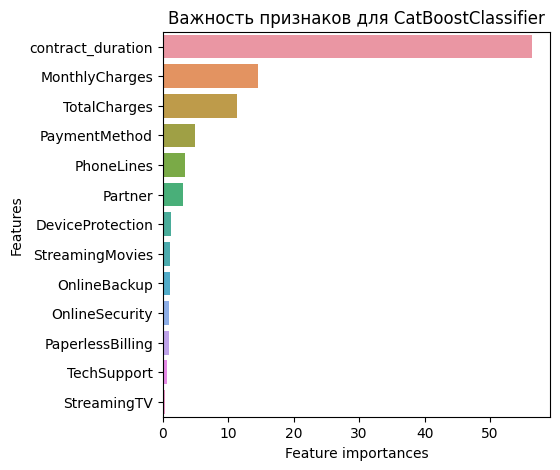

In [102]:
# Посмотрим на важность признаков для CatBoostClassifier

cb_feat_imp = cb.get_feature_importance(prettified=True)

plt.subplots(figsize=(5, 5)) 
ax = sns.barplot(x=cb_feat_imp['Importances'], y=cb_feat_imp['Feature Id']) 
ax.set_title('Важность признаков для CatBoostClassifier') 
ax.set_yticklabels(cb_feat_imp['Feature Id']) 
ax.set_xlabel('Feature importances') 
ax.set_ylabel('Features') 
plt.show()  

### Анализ моделей

In [103]:
models = pd.DataFrame(index = ['log_reg', 'forest', 'lgbm', 'catboost'], 
                      data = [[round(lr_score, 2), 0.68],
                              [round(for_score, 2), 0.74],
                              [round(lgbm_score, 2), 0.87],
                              [0.93, 0.92]],
                      columns = ['ROC-AUC', 'Accuracy'])
models

ROC-AUC  Accuracy
log_reg      0.73      0.68
forest       0.79      0.74
lgbm         0.85      0.87
catboost     0.93      0.92

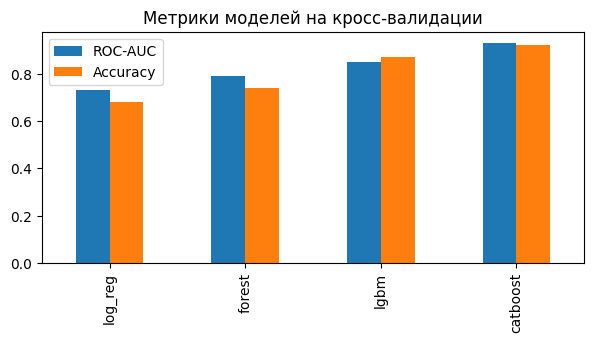

In [104]:
models.plot(kind='bar', figsize = (7, 3), title='Метрики моделей на кросс-валидации');

In [105]:
# Получим предсказаия вероятностей CatBoostClassifier
cb_pred = CatBoostClassifier(cat_features=cat_features, 
                             early_stopping_rounds=200, 
                             depth=4,
                             iterations=1000,
                             learning_rate=0.1, 
                             random_seed=RANDOM_STATE)

catboost_prob = cross_val_predict(cb_pred, features_train, target_train, method='predict_proba', verbose=False)
catboost_prob

0:	learn: 0.6279377	total: 3.57ms	remaining: 3.56s
1:	learn: 0.5665568	total: 7.15ms	remaining: 3.57s
2:	learn: 0.5254437	total: 10.8ms	remaining: 3.6s
3:	learn: 0.4991326	total: 14.2ms	remaining: 3.53s
4:	learn: 0.4733448	total: 17.5ms	remaining: 3.48s
5:	learn: 0.4541838	total: 20.6ms	remaining: 3.4s
6:	learn: 0.4345398	total: 23.7ms	remaining: 3.36s
7:	learn: 0.4233161	total: 26.7ms	remaining: 3.31s
8:	learn: 0.4153773	total: 29.4ms	remaining: 3.23s
9:	learn: 0.4078962	total: 33.6ms	remaining: 3.33s
10:	learn: 0.4005190	total: 36.8ms	remaining: 3.31s
11:	learn: 0.3936729	total: 41ms	remaining: 3.38s
12:	learn: 0.3875203	total: 44.3ms	remaining: 3.36s
13:	learn: 0.3825950	total: 48.2ms	remaining: 3.39s
14:	learn: 0.3781771	total: 51.3ms	remaining: 3.37s
15:	learn: 0.3736445	total: 54.1ms	remaining: 3.33s
16:	learn: 0.3709759	total: 57.2ms	remaining: 3.31s
17:	learn: 0.3683824	total: 61.1ms	remaining: 3.33s
18:	learn: 0.3653896	total: 64ms	remaining: 3.3s
19:	learn: 0.3636794	total: 6

array([[0.85901365, 0.14098635],
       [0.88038158, 0.11961842],
       [0.99875406, 0.00124594],
       ...,
       [0.91838476, 0.08161524],
       [0.11085232, 0.88914768],
       [0.99647899, 0.00352101]])

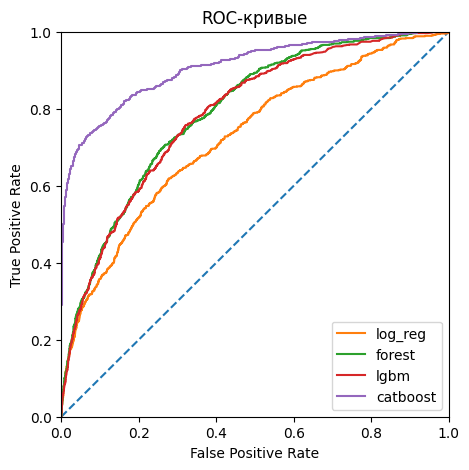

In [106]:
# Построим график ROC-кривых четырех моделей

names = ['lr', 'forest']

for n in names:
    pipe = Pipeline(steps=[('preprocess', preprocessing), ('model', globals()[n])])
    globals()['{}_prob'.format(n)] = cross_val_predict(pipe, features_train, target_train, method='predict_proba')
    globals()['{}_prob_one'.format(n)] = globals()['{}_prob'.format(n)][:,1]
    
lgbm_prob = cross_val_predict(lgbm, lgbm_features_train, target_train, method='predict_proba')
lgbm_prob_one = lgbm_prob[:,1]

catboost_prob_one = catboost_prob[:,1]


plt.figure(figsize=(5, 5)) 
plt.title('ROC-кривые')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

probabilities = [lr_prob_one, forest_prob_one, lgbm_prob_one, catboost_prob_one]
labels = ['log_reg', 'forest', 'lgbm', 'catboost']

for i in range(len(probabilities)):
    fpr, tpr, thresholds = roc_curve(target_train, probabilities[i])
    plt.plot(fpr, tpr, label = labels[i])
    plt.legend()

plt.show()

**Метрики**:

Лучший результат по обеим метрикам показала модель CatBoostClassifier.

**Важность признаков:**

Признак продолжительности контракта является самым важным для всех моделей кроме логистической регрессии, у которой на первом месте - общие траты.  

У остальных моделей общие и ежемесячные траты на 2 и 3 местах. Наличие/отсутствие телефонных линий также является важным признаком, особенно для логистической регрессии, где они занимают второе и третье место. 

В пятерку лидеров входит у всех моделей также входит наличие партнера. 

В целом важность признаков у всех моделей, кроме логистической регрессии совпадает с результатами нашего корреляционного анализа.

Переобучим лучшую модель только на важных признаках.

In [107]:
# Отбросим неважные признаки и оставим 6 самых важных 

features_train_imp = features_train.drop(['OnlineSecurity', 
                                          'OnlineBackup',
                                          'DeviceProtection',
                                          'TechSupport', 
                                          'StreamingTV',
                                          'StreamingMovies', 
                                          'PaperlessBilling'], axis=1)

In [108]:
features_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 2205-LPVGL to 5375-XLDOF
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PaymentMethod      5282 non-null   object 
 1   MonthlyCharges     5282 non-null   float64
 2   TotalCharges       5282 non-null   float64
 3   Partner            5282 non-null   object 
 4   PhoneLines         5282 non-null   object 
 5   contract_duration  5282 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 288.9+ KB


In [109]:
cat_features_imp = ['PaymentMethod',
                    'Partner',
                    'PhoneLines']

In [110]:
# Инициализируем модель CatBoostClassifier с перебором гиперпараметров с помощью функции grid_search

%time

pool = Pool(data=features_train_imp, label=target_train, cat_features=cat_features_imp)

cb = CatBoostClassifier(custom_metric=['AUC', 'Accuracy'], 
                        eval_metric='AUC', 
                        early_stopping_rounds=200, 
                        random_seed=RANDOM_STATE)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'iterations': [1000, 1500]}

rs_result = cb.grid_search(grid, pool, cv=5, plot = True, refit=True, verbose=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7670068	best: 0.7670068 (0)	total: 4.09ms	remaining: 4.08s
1:	test: 0.7654241	best: 0.7670068 (0)	total: 8.39ms	remaining: 4.19s
2:	test: 0.7711645	best: 0.7711645 (2)	total: 12.4ms	remaining: 4.13s
3:	test: 0.7763973	best: 0.7763973 (3)	total: 15.9ms	remaining: 3.97s
4:	test: 0.7702961	best: 0.7763973 (3)	total: 19.3ms	remaining: 3.84s
5:	test: 0.7684879	best: 0.7763973 (3)	total: 22.9ms	remaining: 3.79s
6:	test: 0.7702773	best: 0.7763973 (3)	total: 27.3ms	remaining: 3.87s
7:	test: 0.7716682	best: 0.7763973 (3)	total: 30.7ms	remaining: 3.81s
8:	test: 0.7778333	best: 0.7778333 (8)	total: 33.8ms	remaining: 3.73s
9:	test: 0.7789160	best: 0.7789160 (9)	total: 37.2ms	remaining: 3.69s
10:	test: 0.7802167	best: 0.7802167 (10)	total: 40.8ms	remaining: 3.67s
11:	test: 0.7819046	best: 0.7819046 (11)	total: 43.9ms	remaining: 3.62s
12:	test: 0.7805964	best: 0.7819046 (11)	total: 47ms	remaining: 3.57s
13:	test: 0.7809948	best: 0.7819046 (11)	total: 50.6ms	remaining: 3.56s
14:	test: 0.78

Результат чуть улучшился: по метрике `AUC` - с 0.9251311 до 0.9278829, `Accracy` - c 0.93850520 до 0.93945127.

### Тестирование

In [111]:
features_test_imp = features_test.drop(['OnlineSecurity', 
                                          'OnlineBackup',
                                          'DeviceProtection',
                                          'TechSupport', 
                                          'StreamingTV',
                                          'StreamingMovies', 
                                          'PaperlessBilling'], axis=1)

In [127]:
# Протестируем лучшую модель

predictions = cb.predict(features_test_imp)

prob = cb.predict_proba(features_test_imp)
prob_one = prob[:,1]

auc_roc = roc_auc_score(target_test, prob_one)
accuracy = accuracy_score(target_test, predictions) 

print(f'auc_roc: {auc_roc}')
print(f'accuracy: {accuracy}')

auc_roc: 0.9393406765096477
accuracy: 0.9398069278818852


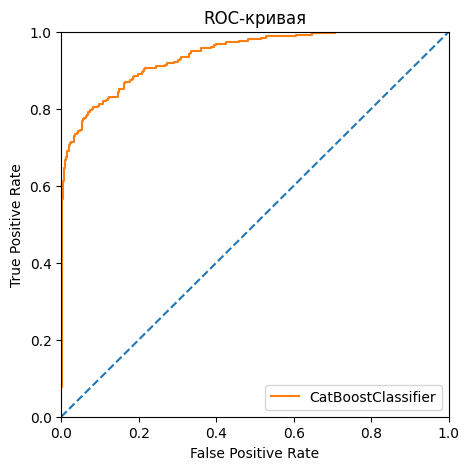

In [128]:
# Построим график ROC-кривой лучшей модели
plt.figure(figsize=(5, 5)) 
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fpr, tpr, thresholds = roc_curve(target_test, prob_one)
plt.plot(fpr, tpr, label = 'CatBoostClassifier')
plt.legend()

plt.show()

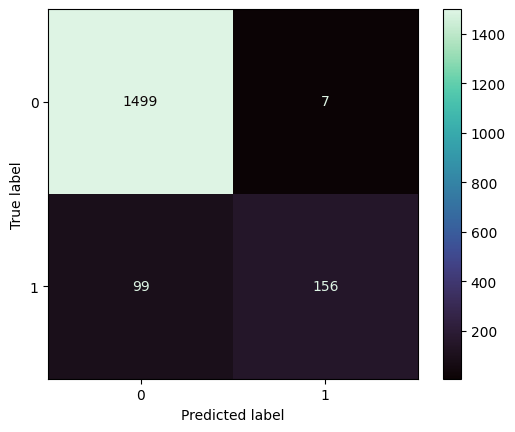

In [129]:
# Построим матрицу ошибок 
cm = confusion_matrix(target_test, predictions, labels=cb.classes_)
disp = ConfusionMatrixDisplay(cm, cb.classes_)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
disp.plot(cmap = 'mako');

Модель ложно предсказывает, что 99 клиентов останутся, хотя на самом деле они уйдут. При этом правильно предсказывает уход 156 клиентов.

Посчитаем, какую прибыль может приносить модель ежемесячно.

In [134]:
df.loc[df['churn'] == 1]['MonthlyCharges'].median()*cm[1][1]\
- df.loc[df['churn'] == 1]['MonthlyCharges'].median()*cm[1][0]

4799.4

Из этой суммы необходимо вычесть расходы на удержание 163-х уходящих клиентов: 156-ти верно предсказанных и 7-ми ложно предсказанных. 

In [135]:
# Рассчитаем отимальный порог для модели
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' %(best_thresh))

Best Threshold: 0.220126


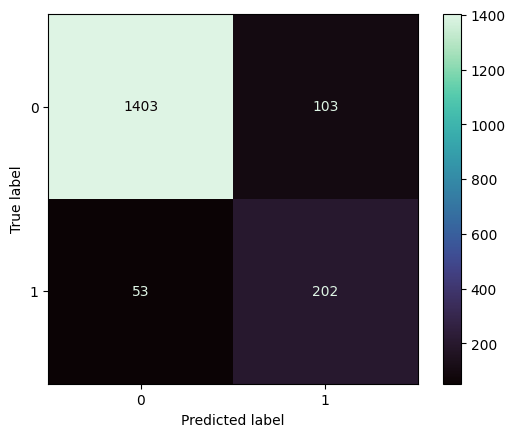

In [136]:
pred = [1 if x >= best_thresh else 0 for x in prob_one]
cm = confusion_matrix(target_test, pred, labels=cb.classes_)
disp = ConfusionMatrixDisplay(cm, cb.classes_)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
disp.plot(cmap = 'mako');

In [137]:
# Посчитаем, как изменится прибыль при изменении порога 
df.loc[df['churn'] == 1]['MonthlyCharges'].median()*cm[1][1]\
- df.loc[df['churn'] == 1]['MonthlyCharges'].median()*cm[1][0]

12545.800000000001

Из этой суммы также придется вычесть расходы на удержание 305 клиентов, что в 1.8 раза больше, чем при пороге 0.5. Зато и прибыль от удержания клиентов при таком пороге в **2.6** раза больше, чем при пороге по умолчанию.

**Вывод**

Мы проанализировали данные о клиентах оператора связи «Ниединогоразрыва.ком».

На этапе предобработки проверили данные на наличие дубликатов, пропущенных значений, аномалий. Создали целевой признак и обработали пропуски.

В ходе исследовательского анализа мы выявили тенденции и закономерности в данных. Провели корреляционный анализ и установили взаимосвязи между признаками.

Мы отобрали признаки для обучения и обучили модели LogisticRegression, RandomForestClassifier, LGBMClassifier,  CatBoostClassifier.

Лучший результат показала модель CatBoostClassifier. На тестовой выборке `ROC-AUC` данной модели составил **0.9393**,
`Accuracy` - **0.9398**.

Мы подобрали оптимальный порог для модели, который позволит в **2.6** раза повысить прибыль от удержания клиентов.

## ОТЧЕТ

1. **Описание проекта**

    В данном проекте мы проанализировали данные о клиентах оператора связи: информацию об их тарифах и договорах, персональные данные.

    Компания предоставляет два основных типа услуг: стационарную телефонную связь и интернет. И дополнительные услуги: возможность подключения телефонного аппарата к нескольким линиям одновременно, антивирус, блокировку небезопасных сайтов, выделенную линию технической поддержки, облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов.

    **Целью проекта** было cоздать прототип модели машинного обучения, прогнозирующей отток клиентов. 

    Мы разделили работу на три этапа:
    - Подготовка данных
    - Анализ данных
    - Построение модели
    

2. **Изучение общей информации**

      На предварительном этапе мы изучили данные и составили план работы. Информация была представлена в четырёх файлах, полученных из разных источников:
    - `contract` — информация о договоре актуальная на 1 февраля 2020
    - `personal` — персональные данные клиента
    - `internet` — информация об интернет-услугах
    - `phone` — информация об услугах телефонии

    В датасете `contract` и `personal` было по **7043** строк.

    Датасет `contract` содержал  **8** столбцов:
    - `customerID`       
    - `BeginDate` (дата заключения договора)       
    - `EndDate` (дата окончания договора)          
    - `Type` (тип договора: с оплатой каждый месяц, на 1 год или на 2 года)             
    - `PaperlessBilling` (возможность получения электронного счета) 
    - `PaymentMethod` (способы расчёта)     
    - `MonthlyCharges` (ежемесячные траты на услуги)    
    - `TotalCharges` (общая сумма трат) 

    Датасет `personal` содержал -  **5** столбцов:
    - `customerID`     
    - `gender` (пол)        
    - `SeniorCitizen` (наличие пенсионного статуса по возрасту) 
    - `Partner` (наличие супруга(и))     
    - `Dependents` (наличие иждивенцев)   
 
    В датасете `internet` было **5517** строк и **8** столбцов:
    - `customerID`        
    - `InternetService` (тип подключеия к итенету: через телефонную линию (*DSL*) или оптоволоконный кабель (*Fiber optic*))     
    - `OnlineSecurity` (блокировка небезопасных сайтов )    
    - `OnlineBackup` (облачное хранилище файлов для резервного копирования данных )     
    - `DeviceProtection` (интернет-безопасность: антивирус) 
    - `TechSupport` (выделенная линия технической поддержки)      
    - `StreamingTV` (cтриминговое телевидение)      
    - `StreamingMovies` (каталог фильмов)  

    В датасете `phone` - **6361** и **2** столбца:
    - `customerID`    
    - `MultipleLines` (возможность подключение телефонного аппарата к нескольким линиям одновременно)

    Во всех файлах столбец `customerID` содержал код клиента.

    Все признаки, кроме двух, имели тип данных *object*. Столбец `MonthlyCharges` - тип *float64*, столбец `SeniorCitizen` - *int64*

    Целевой признак отсутствовал.


3. **Предобработка данных**
 
    3.1 **Проверка наличия дубликатов и объединение данных**

    На этапе  предобработки мы убедились в отсутствии в данных полных дубликатов и дубликатов идентификаторов клиентов. 
    
    Сделали столбец `customerID` индексом и объединили все таблицы методом *join*.

   3.2 **Создание целевого признака**

    Мы создали бинарный целевой признак - `churn` (отток клиентов) - из данных столбца `EndDate`, назначив положительный класс `1` ушедшим клиентам, у которых была указана дата окончания договора, и отрицательный класс `0` - оставшимся клиентам, у которых в столбце `EndDate` стояло значение `'No'`.

    Классы целевого признака оказались не сбалансированными. Ушедших клиетов в пять раз меньше, чем оставшихся.

    3.4 **Изменение типов данных**

    Мы изменили тип данных столбце `TotalCharges` на *float64* в соответсвии с его числовыми значениями. 

    Мы также заменили типы данных на *datetime* в двух столбцах с датами, на *object* - в столбце `SeniorCitizen`, и на *int64* - в столбце `churn`.    

    3.5 **Обработка пропусков и аномалий**

    Мы заменили значения `'No'` в столбце `EndDate` у клиентов, чей договор все еще действует, на актуальную дату `2020-02-01`, предварительно проверив, что такой даты окончания договора нет у ушедших пользователей.

    При смене типа данных мы обнаружили 11 пустых строк столбце `TotalCharges`. Мы изучили эти строки и выяснили, что пользователи заключили договоры `2020-02-01` - это актуальная дата, на которую были предоставлены данные. Скорее всего, новые клиенты еще не успели оплатить услуги. Однако столбец `MonthlyCharges` у этих клиентов заполнен. Поэтому мы заменили эти пропуски в `TotalCharges` платой за месяц.

    Мы проверили данные на наличие пропусков. В столбцах из таблицы `internet` было пропущено  **1526** значений. Вероятно, у клиентов, которые не пользуются услугами интернета. 

    Мы добавили категорию `'No'` в  столбец `InternetService`, заменив ею пропуски. В остальных столбцах из таблицы `internet` также заменим пропуски на `'No'`.

    В столбце `MultipleLines` из таблицы `phone` обнаружились **682** пропуска у клиентов, которые не пользуются услугами телефонии. 

    Мы добавили новую категорию, в столбец `MultipleLines`, заменив ею пропуски. Обозначим новую категорию как `'No'`, а существующие категории переименовали в `'One'` и `'Multi'` по количеству телефонных линий. Сам столбец переиминовали в `PhoneLines`.

    Мы также убедились в отсутсвии в данных аномалий. 
    

4. **Исследовательский анализ данных**

    4.1 **Динамика заключения и расторжения договоров**

    На этапе исследовательского анализа мы изучили каждый признак, выявили взаимосвязи, закономерности и тенденции и составили портрет уходящего клиента.

    Мы исследовали димамику заключения договоров на графике и обнаружили, что пик приходится на 2014 год, затем график выходит на плато с небольшими локальными пиками. В 2019 количество договоров начинает расти.

    Мы также изучили динамику прекращенных договоров, и выяснили, что их количество постоянно растет.

    Однако отток и приток клиентов не так заметны на фоне количества активных клиентов, которое неизменно увеличивается.

    Доля расторгнутых договоров от активных клиентов почти нулевая и почти не меняется. При этом доля заключенных договоров стабильно больше и в последнее время подросла.

    На основе информации о датах начала и заверешния договоров мы **создали новый признак** - `contract_duration` (продолжительность договора).

    4.2 **Портрет пользователя**

    Мы построили график плотности продолжительности договора у уходящих и оставшихся клиентов и обнаружили, что в среднем клиенты уходят через **2.5** года, но после этого отток идет а спад, а после **5.5** совсем прекращается.

    Мы также выяснили с помощью метода *describe* и столбчатых диаграмм, что у оставшихся клиентов средняя и медианная продолжительность договора меньше, чем у ушедших. 

    Мы также изучили распределения ежемесячных и общих трат с помощью гистограмм, графиков плотности метода *describe*. Ушедшие клиенты в среднем тратят больше оставшихся, как ежемесячно, так и в общем. Медианные общие траты уходящих клиентов в **1.8** раза превышают траты оставшихся. 

   Мы построили столбчатные и круговые диагаммы по каждому из категориальных признаков и выяснили предпочтения уходящих и оставшихся пользователей.

    Оставшиеся клиенты предпочитают, помесячные контракты, в то время как у ушедших типы контрактов распределены примерно в равных долях.

    Ушедшие клиенты больше любят электронное выставление счетов и электронные способы оплаты.

    Среди ушедших чуть больше пенсионеров и намного больше состоящих в браке.

    Среди уходящих клиентов больше пользователей интернета. При этом они предпочитают оптоволокно и несколько линий телефонной связи.

    Ушедшие клиенты больше пользуются всеми дополнительными интернет-услугами.

    4.3 **Корреляционный анализ**

   Мы провели корреляционный анализ с помощью библиотеки *phik*, выявили взаимосвязи между признаками, обнаружили мультиколлинеарность.

    Продолжительность контракта показала наиболее сильную связь с оттоком. На втором месте с большим отрывом - дата заключения договора, на третьем - общие траты.

    Пол, наличие иждивенцев и пенсионного статуса, интернет, электронные счета и тип договора почти не коррелируют с оттоком. Использование услуг телефонии и дополнительные интернет-услуги - техподдежка и онлайн безопасность коррелируют слабо. Чуть сильнее - стриминговые услуги, антивирус и облачное хранилище, наличие партнера.

    Ежемесяные траты сильно коррелируют с услугами интренета, телефонии и стриминга, а общие траты с продолжительностью контракта и датой заключения. Также с продолжительностью и датой заключения коррелирует тип договора.

    Стримиг фильмов и ТВ коррелируют между собой, очевидно клиенты подключают их вместе. В целом дополнительные услуги достаточно сильно связаны с тратами.

    4.3 **Отбор призаков**
 
    Мы выбрали признаки для обучения моделей, удалив столбцы, которые сильно коррелируют с тратами и при этом почти не влияют на целевой: тип договора и интернет, и другие признаки, которые почти не связаны с целевым: пол, наличие иждивенцев и пенсионного статуса.

    Кроме того, мы удалили признаки, которые содержат утечку целевого признака: дата начала и окончания договора. 
    

5. **Обучение моделей**

   Мы разделили данные на обучающую и тестовую выборки в соотношении 75:25, создали *pipeline* для стандартизации числовых, OHE-кодирования категориальных признаков и обучения моделей.

    Мы обучили четыре модели классификации *LogisticRegression*, *RandomForestClassifier*, *LGBMClassifier*, *CatBoostClassifier*. 

    Для первых трёх моделей мы настраивали гиперпараметры с помощью библиотеки *optuna* и проверяли качество модели на кросс-валидации с помощью *cross_validate*. 

    Для *CatBoostClassifier* мы перебирали гиперпараметры с помощью функции *grid_search*.

    Мы также вывели графики важности признаков для каждой модели. 

    Признак продолжительности контракта оказался самым важным для всех моделей кроме логистической регрессии, у которой на первом месте - общие траты.

    У остальных моделей общие и ежемесячные траты на 2 и 3 местах. Наличие/отсутствие телефонных линий - также  важный признак, особенно для логистической регрессии, где они занимают второе и третье место.

    В пятерку лидеров у всех моделей также вошло наличие партнера.

    В целом важность признаков у всех моделей, кроме логистической регрессии совпала с результатами корреляционного анализа.

    Мы построили графики ROC-кривых чытырех моделей и сравнили их качество. 
    В качестве метрики качества моделей мы использвали `ROC-AUC`, дополнительно измеряли `Accuracy`.

    Лучший результат по обеим метрикам на кросс-валидации показала модель *CatBoostClassifier* с гиперпараметрами early_stopping_rounds=200, depth=4, iterations=1000, learning_rate=0.1:

    `ROC-AUC`: **0.93**	

    `Accuracy`: **0.92**

    Мы переобучили лучшую модель на шести самых важных признаках и протестировали. 

    На тестовой выборке данная модель показала результат
    
    `ROC-AUC`: **0.9393**

    `Accuracy`: **0.9398**

    Мы построили матрицу ошибок модели, провели финансовый анализ прибыли\издержек от ее применения и рассчитали оптимальный порог для максимизации прибыли.

    При смене порога с 0.5 на 0.22 прибыль от удержания клиентов увеличится в **2.6** раза с 4799.4 до 12545.8.
    

6. **Вывод**

    В ходе исследования все ли пункты изначального плана были реализованы.
    
    Основные трудности возникли в связи с 
    - представлением данных в нескольких файлах
    - отсутствием целевого признака
    - отсутствием отдельных категорий для основных услуг телефонии и интернета
    - наличием пустных строковых значений в столбце `TotalCharges` и значений `'No'` в столбце `EndDate`
    - не соответствием типов данных значениям столбцов `TotalCharges` и `SeniorCitizen`
    
   Ключевыми шагами в ходе проекта были:
   - создание целевого признака 
   - создание нового признака `contract_duration` (продолжительность договора), который оказался важнейшим для модели
   - проверка на мультиколлинеарность и отбор признаков с её учетом
   - выбор моделей для обучения и подбор оптимального порога